In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

In [2]:
PATH = Path('.')

In [3]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
train_ds = datasets.MNIST(PATH / "MNIST", train=True, transform=tfms, download=True)
test_ds = datasets.MNIST(PATH / "MNIST", train=False, transform=tfms, download=True)

In [6]:
train_dl = data.DataLoader(train_ds, batch_size=36)
test_dl = data.DataLoader(test_ds, batch_size=36, shuffle=False)

In [7]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [8]:
def plot_losses(trn_losses, tst_losses):
    plt.figure(figsize=(12,6))
    plt.plot(tst_losses, color='green', label="test")
    plt.plot(trn_losses, color='blue', label="train")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_ae(ae, img):
    ae.eval()
    output = ae(img.to(device))
    plot_mnist(img, (6,6))
    plot_mnist(output.data.cpu().numpy(), (6,6))

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), pl = nn.MaxPool2d(2, stride=2), **kwargs):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(sz[0], sz[1], sz[2], **kwargs))
        if pl:
            layers.append(pl)
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class ConvTLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(sz[0], sz[1], sz[2], **kwargs))
        if bn:
            layers.append(nn.BatchNorm2d(sz[1]))
        if dp:
            layers.append(nn.Dropout2d())
        layers.append(a_fn)
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [12]:
class LinearLayer(nn.Module):
    def __init__(self, sz, bn=False, dp=False, a_fn=nn.ReLU(), **kwargs):
        super().__init__()
        layers = []
        
        for i in range(len(sz)-2):
            layers.append(nn.Linear(sz[i], sz[i+1]))
            if bn:
                layers.append(nn.BatchNorm1d(sz[i+1]))
            if dp:
                layers.append(nn.Dropout())
            layers.append(a_fn)
        layers.append(nn.Linear(sz[-2], sz[-1]))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [13]:
class ConvolutionalAE(nn.Module):
    def __init__(self, linear_sizes=None, bn=False, dp=False):
        super().__init__()
        self.linear_sizes = linear_sizes
        self.name = f'ConvAE BN={bn} DP={dp} FC={self.linear_sizes}'
        a_fn = nn.ReLU() if linear_sizes else nn.Tanh()
        self.cnn_encoder = nn.Sequential(
            ConvLayer((1,16,3), bn=bn, dp=dp, padding=1),
            ConvLayer((16,32,3), bn=bn, dp=dp, a_fn=a_fn, padding=1)
        )
        if linear_sizes:
            self.fc_encoder = nn.Sequential(
                LinearLayer([32*7*7, *linear_sizes], bn=bn, dp=dp),
                nn.Tanh()
            )

            self.fc_decoder = nn.Sequential(
                LinearLayer([*linear_sizes, 32*7*7], bn=bn, dp=dp),
                nn.ReLU()
            )

        self.cnn_decoder = nn.Sequential(
            ConvTLayer((32,16,3), bn=bn, dp=dp, stride=2),
            ConvTLayer((16,1,3), bn=False, dp=False, a_fn=nn.Tanh(), padding=2, stride=2, output_padding=1)
        )
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28,
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2),  # 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),  # 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  # 32 x 7 x 7
        )
        self.fc_encoder = nn.Sequential(
            nn.Linear(32*7*7, linear_sizes[0]),
            nn.BatchNorm1d(linear_sizes[0]),
            nn.ReLU(),
            nn.Linear(linear_sizes[0], linear_sizes[1]),
            nn.Tanh()
        )
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(linear_sizes[1], linear_sizes[0]),
            nn.BatchNorm1d(linear_sizes[0]),
            nn.ReLU(),
            nn.Linear(linear_sizes[0], 32*7*7),
            nn.BatchNorm1d(32*7*7),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2), # 16 x 15 x 15
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=2, stride=2, output_padding=1), # 1 x 28 x 28
            nn.Tanh()
        )
        """
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        self._loss = None
        
    def forward(self, x):
        x =self.cnn_encoder(x)
        if self.linear_sizes:
            x = F.relu(x)
            x = x.view(x.shape[0], -1)
            x = self.fc_encoder(x)
            x = self.fc_decoder(x)
            x = x.view(x.shape[0], 32, 7, 7)
        else:
            x = F.tanh(x)
        x = self.cnn_decoder(x)
        
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.mse_loss(output, target, **kwargs)
        return self._loss

In [14]:
models = [ConvolutionalAE().to(device), 
          ConvolutionalAE((128, 128)).to(device),
          ConvolutionalAE((1024, 1024)).to(device),
          ConvolutionalAE((2048, 2048)).to(device),
          ConvolutionalAE(bn=True).to(device), 
          ConvolutionalAE((128, 128), bn=True).to(device),
          ConvolutionalAE((1024, 1024), bn=True).to(device),
          ConvolutionalAE((2048, 2048), bn=True).to(device),
          ConvolutionalAE(bn=True, dp=True).to(device), 
          ConvolutionalAE((128, 128), bn=True, dp=True).to(device),
          ConvolutionalAE((1024, 1024), bn=True, dp=True).to(device),
          ConvolutionalAE((2048, 2048), bn=True, dp=True).to(device)]

In [15]:
for m in models:
    print(f"\n------------- {m.name} -------------\n")
    print(m)


------------- ConvAE BN=False DP=False FC=None -------------

ConvolutionalAE(
  (cnn_encoder): Sequential(
    (0): ConvLayer(
      (model): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): ConvLayer(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): Tanh()
      )
    )
  )
  (cnn_decoder): Sequential(
    (0): ConvTLayer(
      (model): Sequential(
        (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU()
      )
    )
    (1): ConvTLayer(
      (model): Sequential(
        (0): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
        (1): Tanh()
      )
    )
  )
)

----------

In [16]:
def train(models, train_dl, test_dl):
    train_loss = [0.]*len(models)
    train_size = len(train_dl)
    
    test_loss = [0.]*len(models)
    test_size = len(test_dl)
    
    for data, _ in train_dl:
        data = data.to(device)
        for i, m in enumerate(models):
            m.train()
            m.optim.zero_grad()
            output = m(data)
            loss = m.loss(output, data)
            loss.backward()
            m.optim.step()
            train_loss[i] += m._loss.item()
        
    for data, _ in test_dl:
        data = data.to(device)
        for i, m in enumerate(models):
            m.eval()
            output = m(data)
            loss = m.loss(output, data)
            test_loss[i] += m._loss.item()

    print(f"Epoch {epoch}:")
    for i, m in enumerate(models):
        train_loss[i] /= train_size
        test_loss[i] /= test_size
        print("  Loss for {0:45s}: {1:2.5f} / {2:2.5f}".format(m.name, train_loss[i], test_loss[i]))
        
    return zip(train_loss, test_loss)

In [17]:
train_losses = [[] for i in range(len(models))]
test_losses = [[] for i in range(len(models))]

Epoch 1:
  Loss for ConvAE BN=False DP=False FC=None             : 0.20689 / 0.05215
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.30840 / 0.27185
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.29876 / 0.27398
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.28264 / 0.27260
  Loss for ConvAE BN=True DP=False FC=None              : 0.26339 / 0.05576
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.29668 / 0.15946
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.29194 / 0.12792
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.25757 / 0.06614
  Loss for ConvAE BN=True DP=True FC=None               : 0.36648 / 0.09188
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.40444 / 0.21879
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.39072 / 0.17441
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.33931 / 0.11648
Epoch 2:
  Loss for ConvAE BN=False DP=False FC=None             : 0.03613 / 0.

Epoch 10:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00971 / 0.00920
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26924 / 0.27128
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26932 / 0.27136
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26933 / 0.27132
  Loss for ConvAE BN=True DP=False FC=None              : 0.00797 / 0.00779
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.03371 / 0.02811
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.01302 / 0.01582
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.01004 / 0.01555
  Loss for ConvAE BN=True DP=True FC=None               : 0.05703 / 0.02736
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.15642 / 0.11210
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.08176 / 0.04592
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.06939 / 0.03543

------------- ConvAE BN=False DP=False FC=None -------------



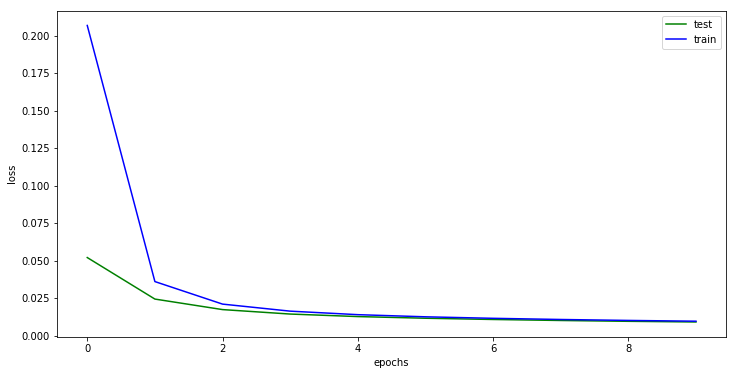

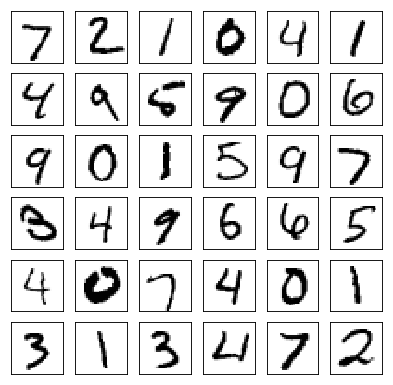

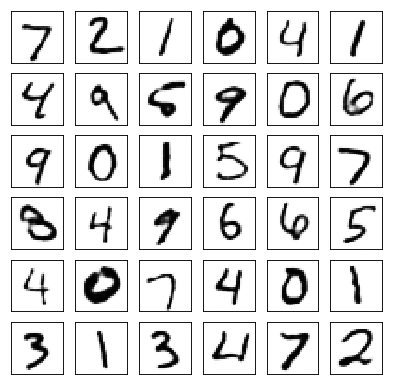


------------- ConvAE BN=False DP=False FC=(128, 128) -------------



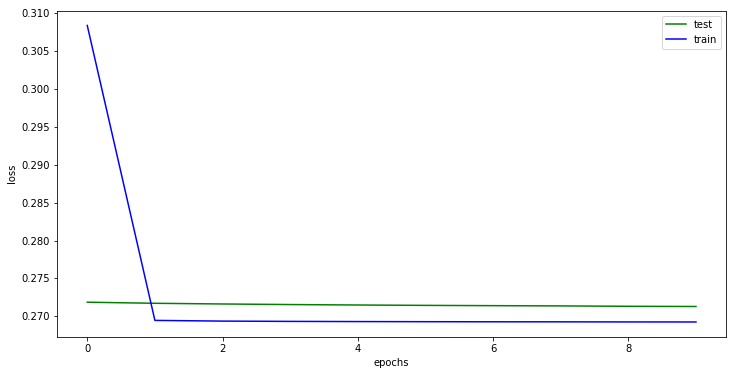

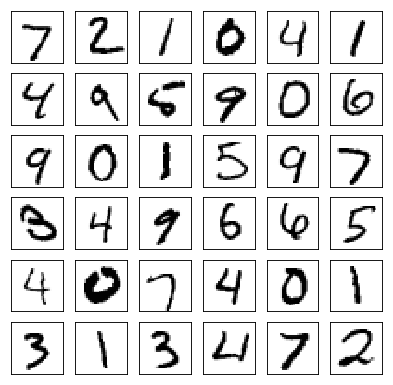

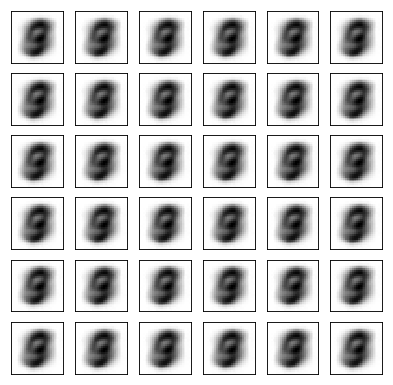


------------- ConvAE BN=False DP=False FC=(1024, 1024) -------------



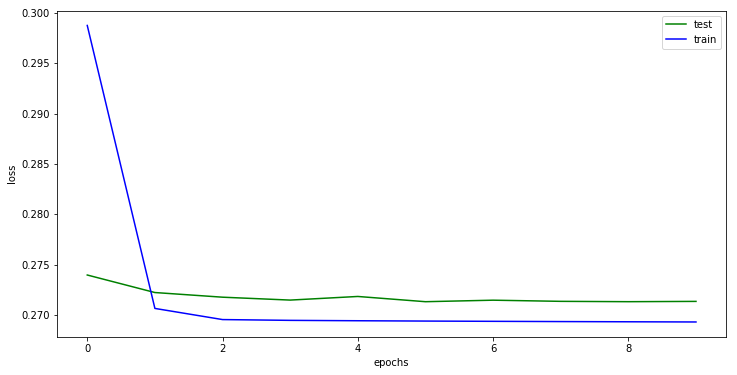

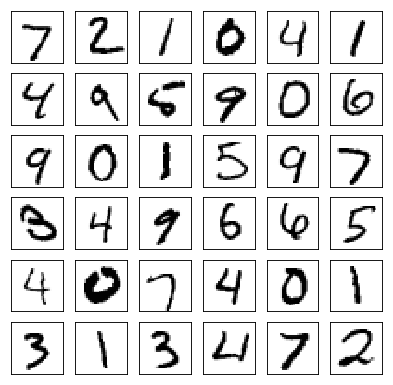

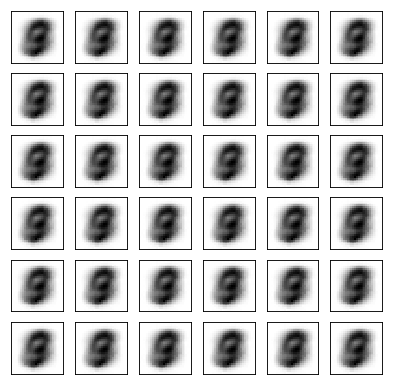


------------- ConvAE BN=False DP=False FC=(2048, 2048) -------------



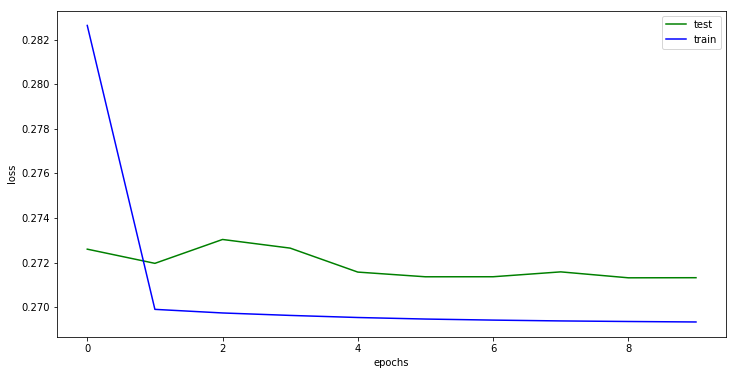

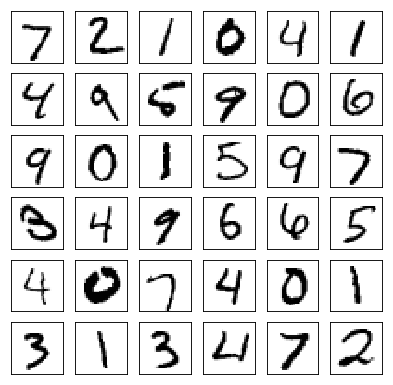

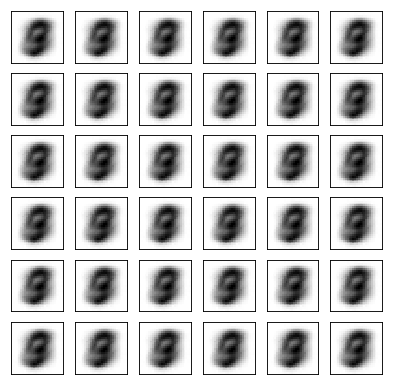


------------- ConvAE BN=True DP=False FC=None -------------



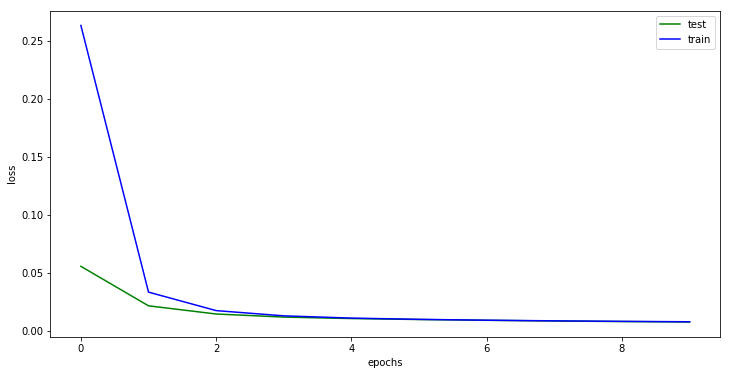

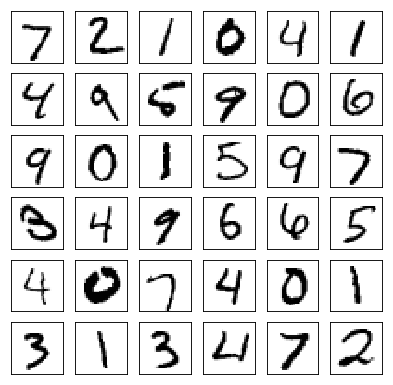

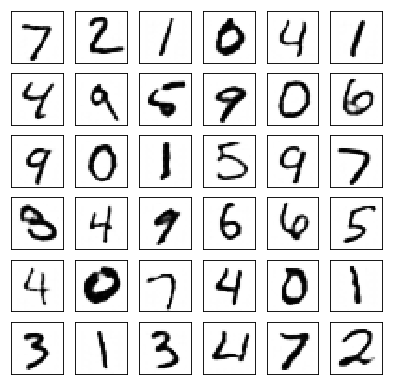


------------- ConvAE BN=True DP=False FC=(128, 128) -------------



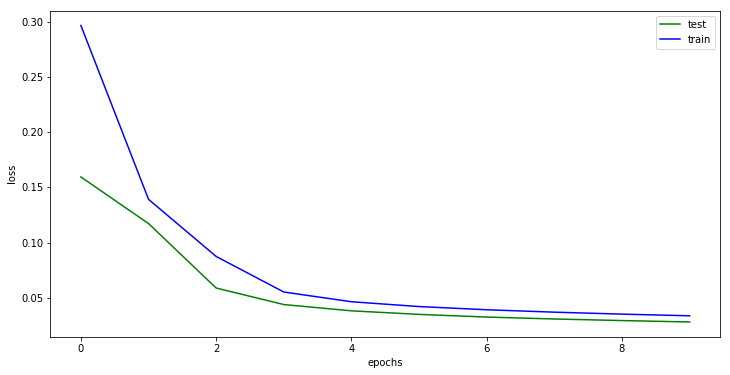

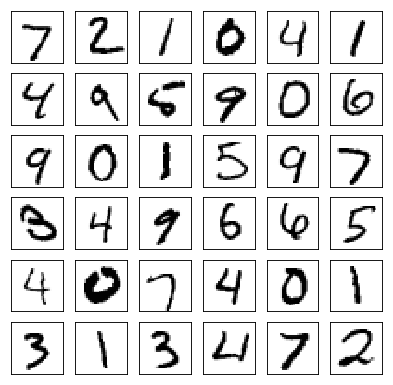

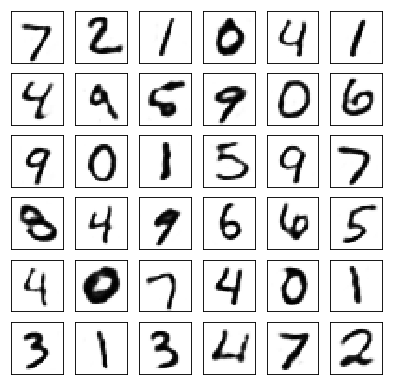


------------- ConvAE BN=True DP=False FC=(1024, 1024) -------------



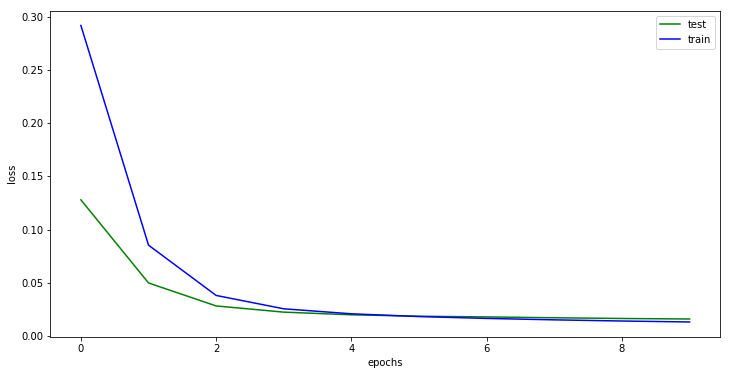

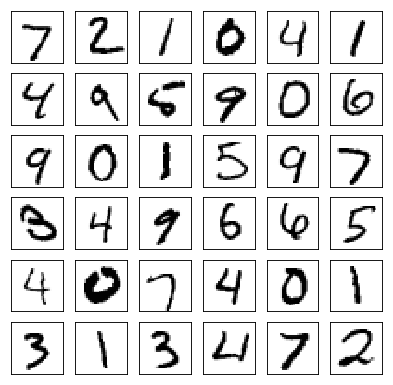

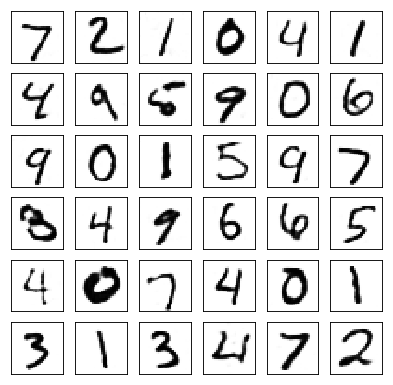


------------- ConvAE BN=True DP=False FC=(2048, 2048) -------------



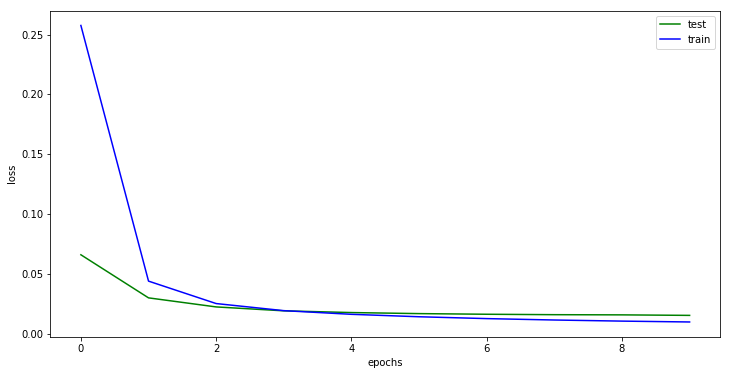

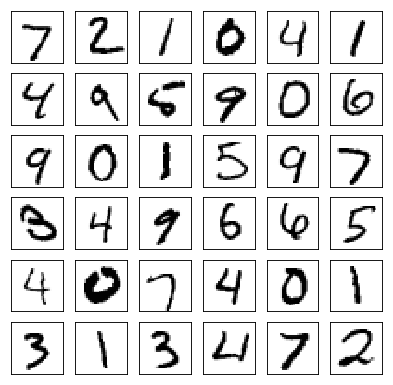

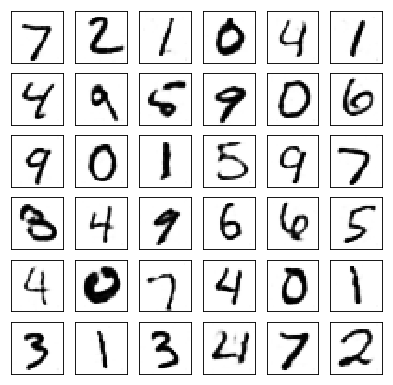


------------- ConvAE BN=True DP=True FC=None -------------



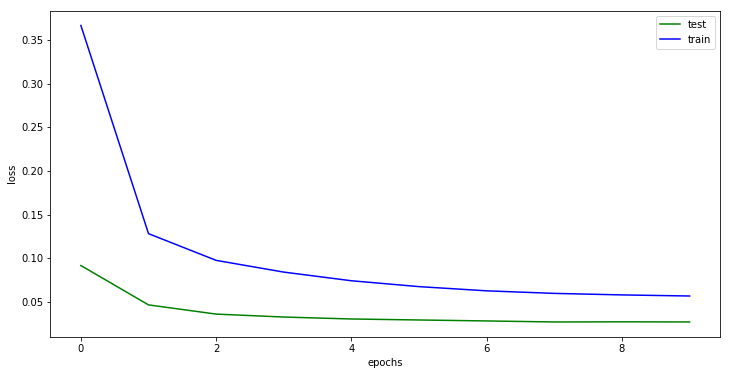

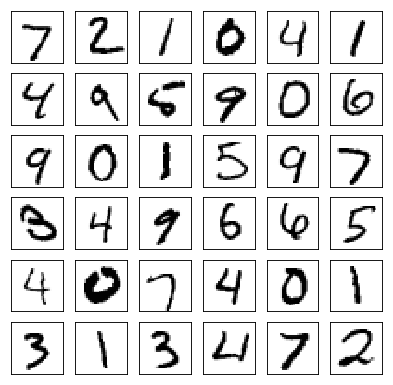

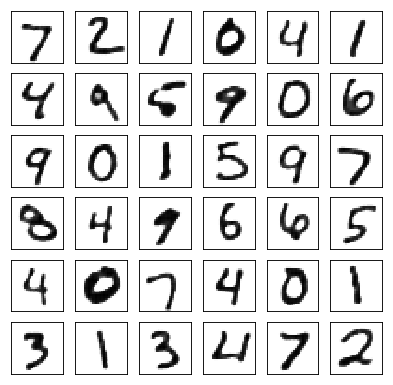


------------- ConvAE BN=True DP=True FC=(128, 128) -------------



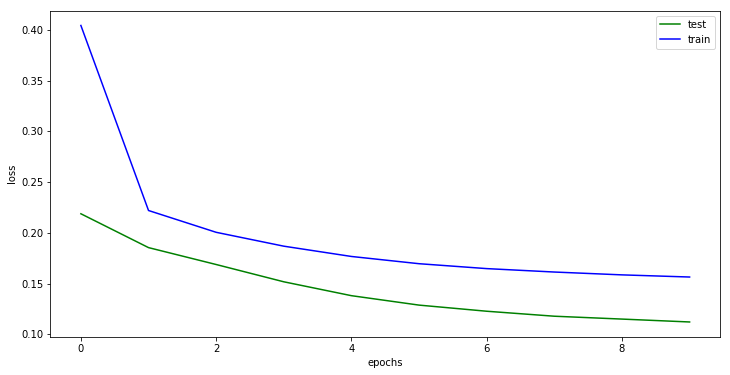

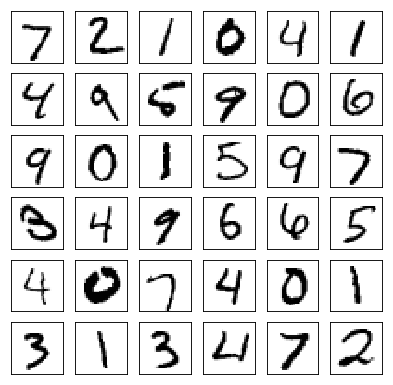

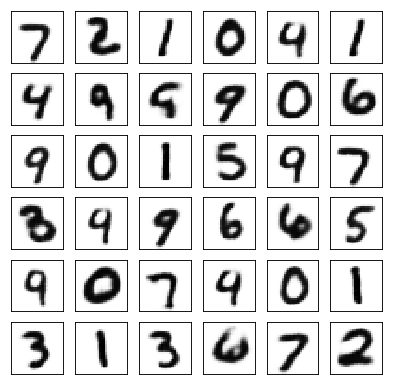


------------- ConvAE BN=True DP=True FC=(1024, 1024) -------------



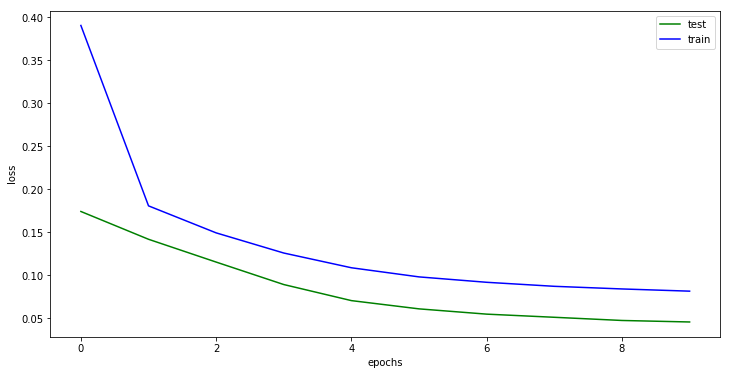

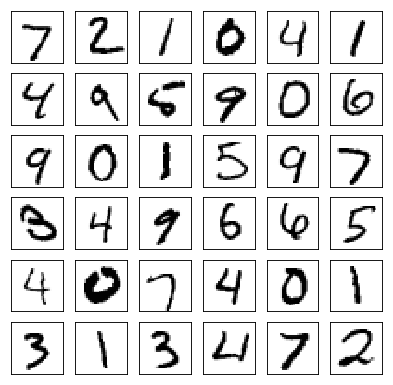

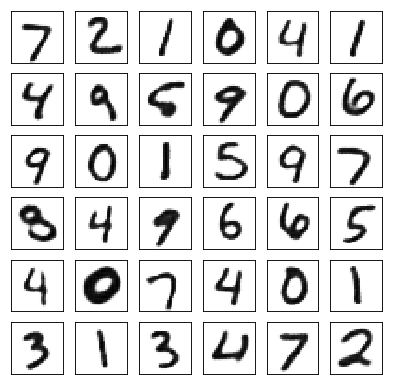


------------- ConvAE BN=True DP=True FC=(2048, 2048) -------------



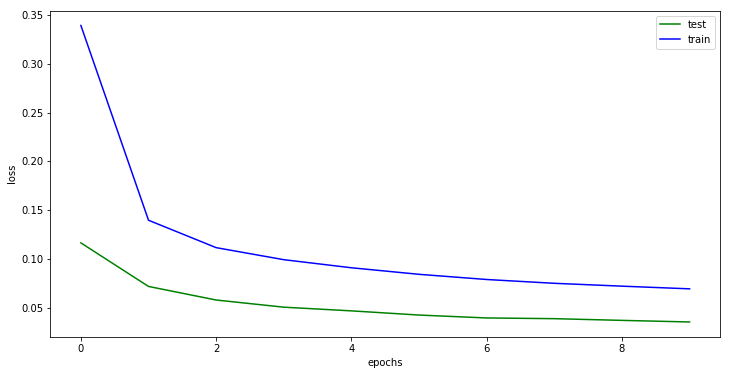

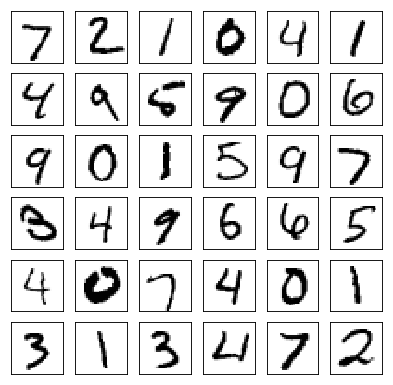

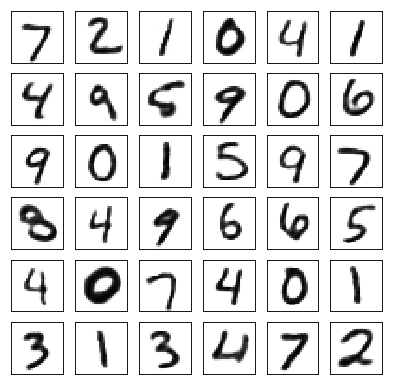

Epoch 11:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00928 / 0.00883
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26924 / 0.27127
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26930 / 0.27143
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26932 / 0.27121
  Loss for ConvAE BN=True DP=False FC=None              : 0.00768 / 0.00751
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.03240 / 0.02694
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.01227 / 0.01549
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00947 / 0.01551
  Loss for ConvAE BN=True DP=True FC=None               : 0.05647 / 0.02732
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.15483 / 0.10898
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.07956 / 0.04454
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.06756 / 0.03471
Epoch 12:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00892 / 

Epoch 20:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00726 / 0.00703
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26920 / 0.27109
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26922 / 0.27139
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26925 / 0.27115
  Loss for ConvAE BN=True DP=False FC=None              : 0.00633 / 0.00623
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.02511 / 0.02125
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.00873 / 0.01476
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00702 / 0.01459
  Loss for ConvAE BN=True DP=True FC=None               : 0.05330 / 0.02710
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.14586 / 0.09864
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.06986 / 0.03630
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.05761 / 0.02949

------------- ConvAE BN=False DP=False FC=None -------------



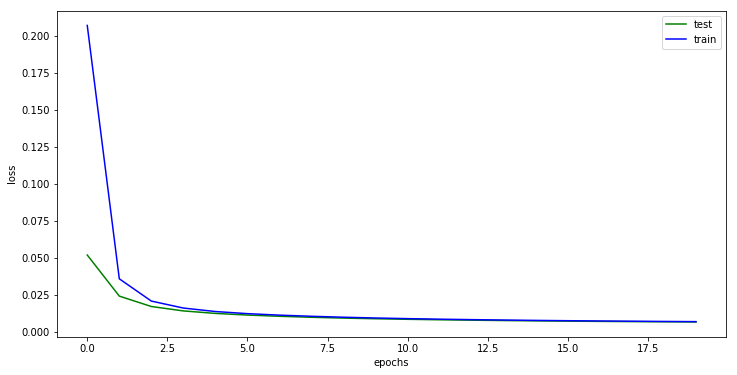

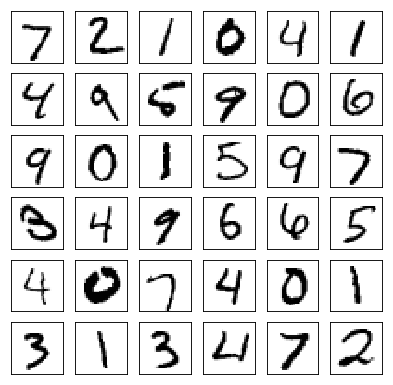

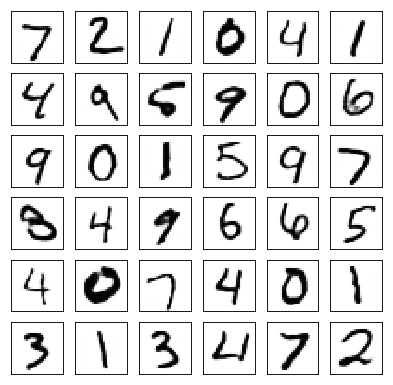


------------- ConvAE BN=False DP=False FC=(128, 128) -------------



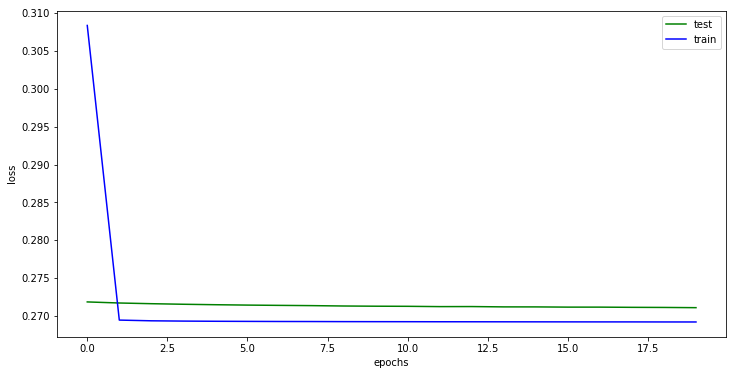

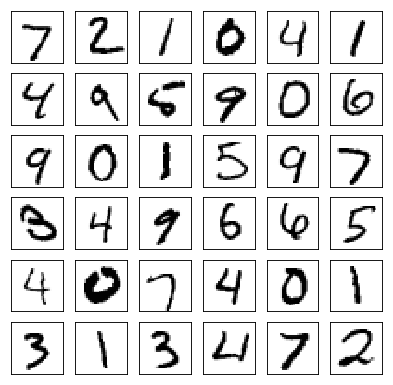

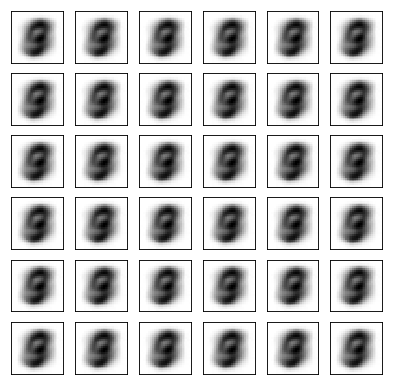


------------- ConvAE BN=False DP=False FC=(1024, 1024) -------------



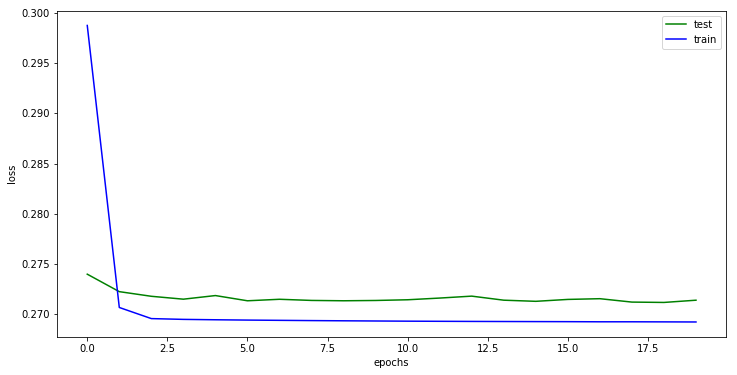

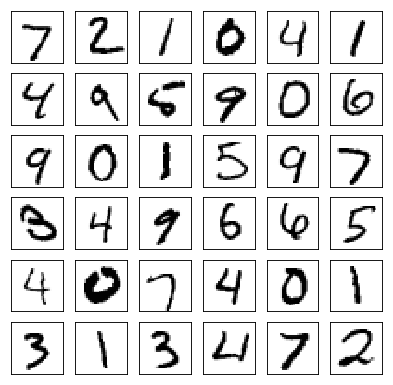

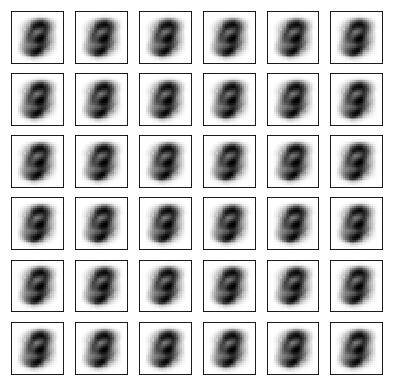


------------- ConvAE BN=False DP=False FC=(2048, 2048) -------------



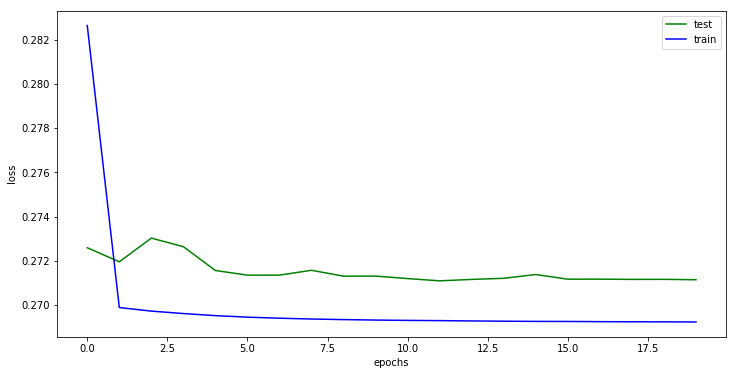

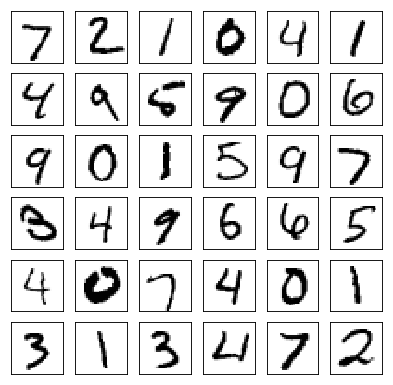

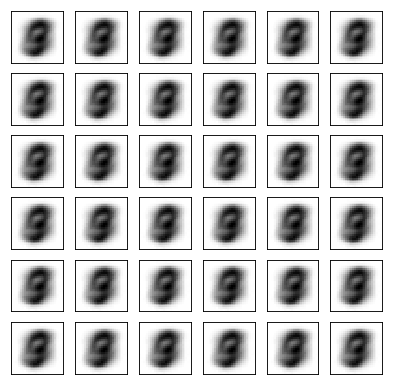


------------- ConvAE BN=True DP=False FC=None -------------



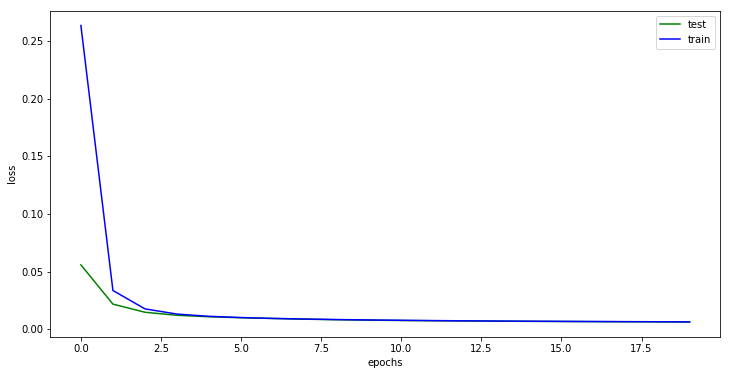

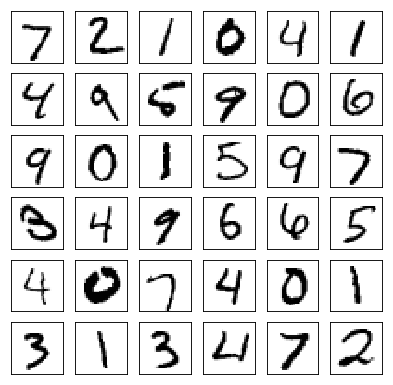

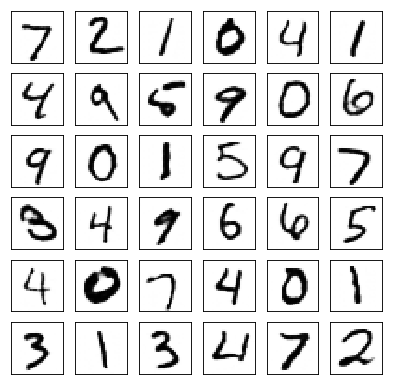


------------- ConvAE BN=True DP=False FC=(128, 128) -------------



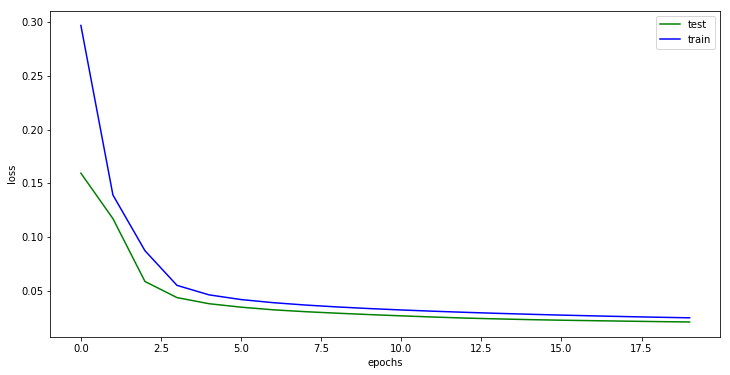

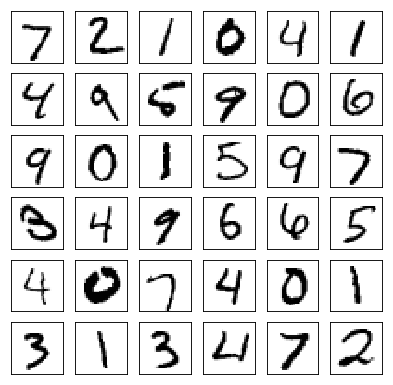

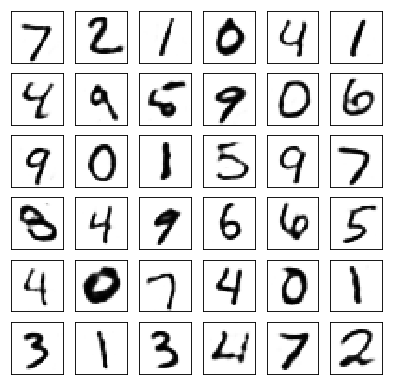


------------- ConvAE BN=True DP=False FC=(1024, 1024) -------------



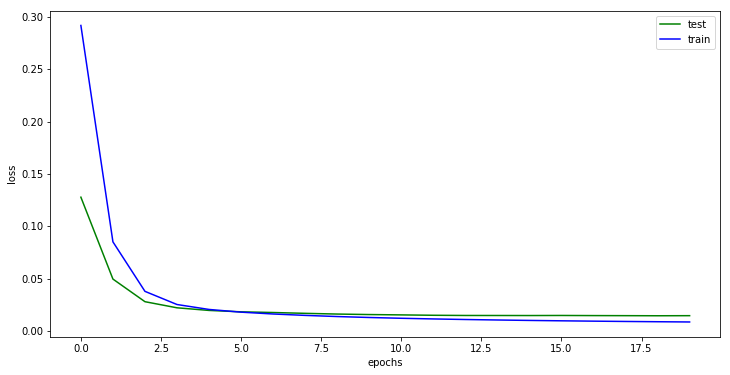

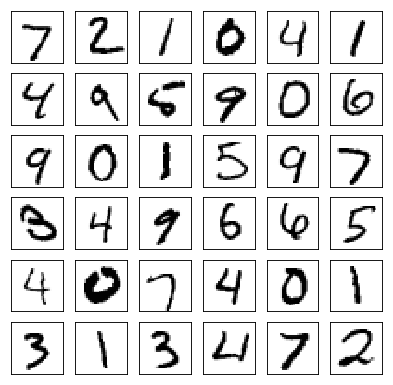

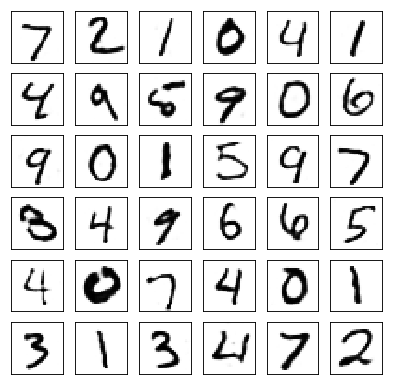


------------- ConvAE BN=True DP=False FC=(2048, 2048) -------------



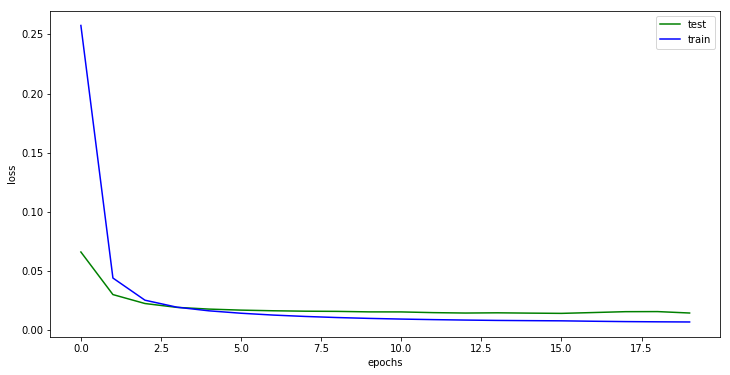

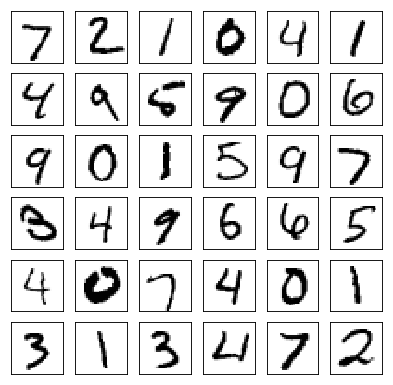

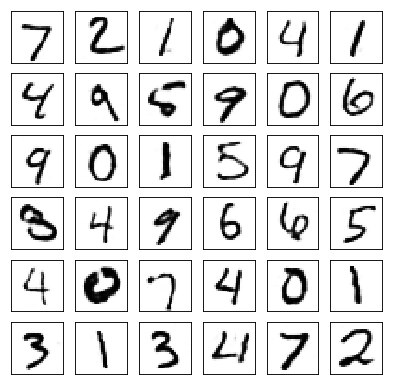


------------- ConvAE BN=True DP=True FC=None -------------



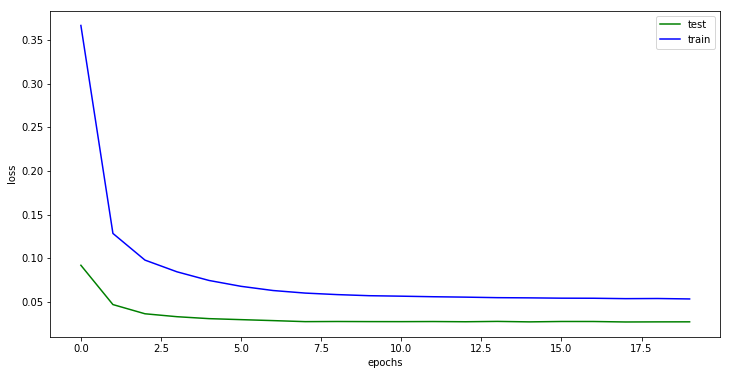

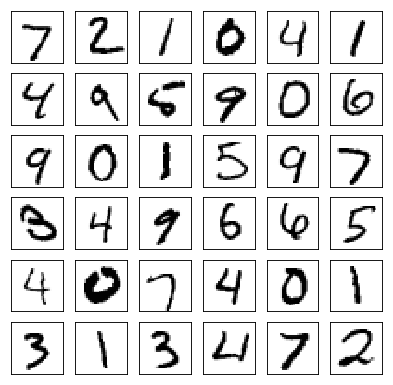

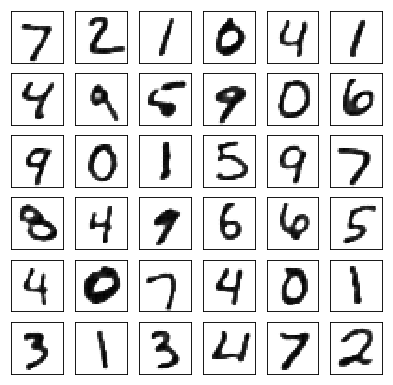


------------- ConvAE BN=True DP=True FC=(128, 128) -------------



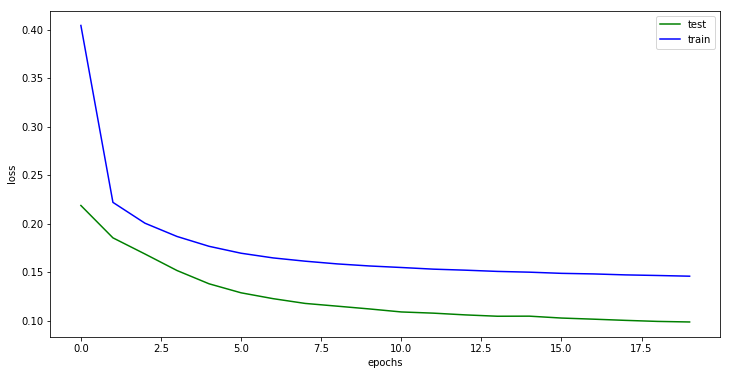

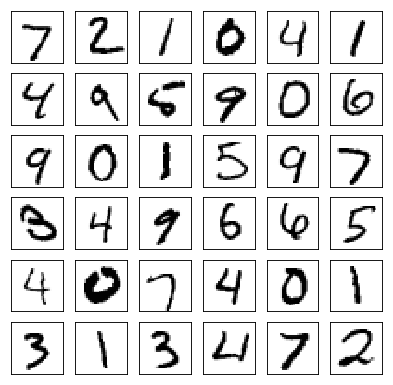

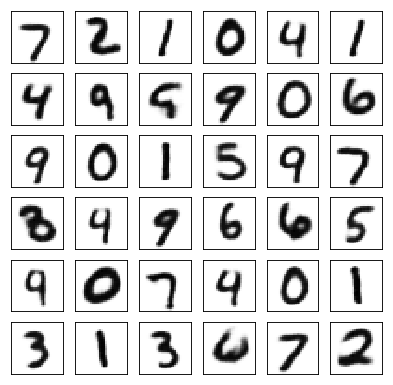


------------- ConvAE BN=True DP=True FC=(1024, 1024) -------------



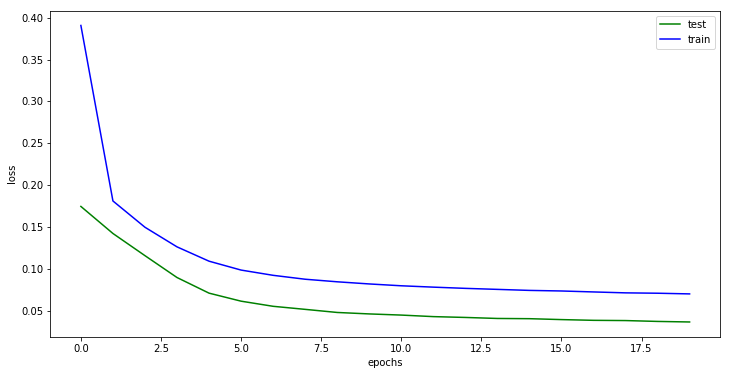

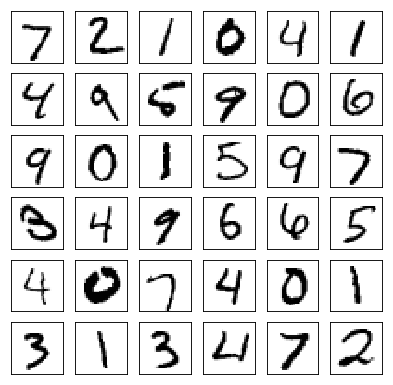

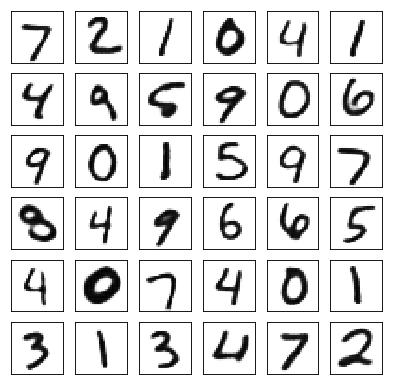


------------- ConvAE BN=True DP=True FC=(2048, 2048) -------------



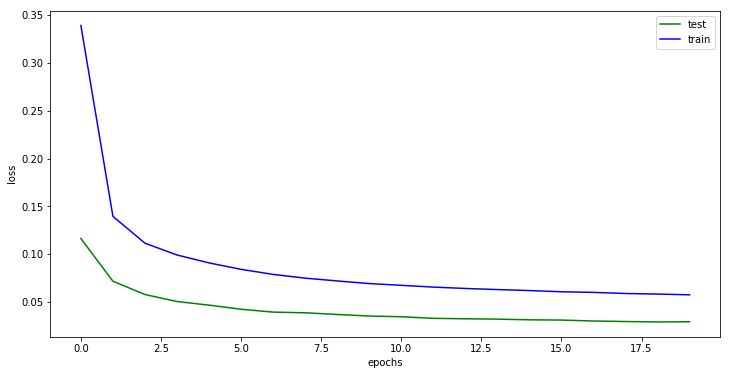

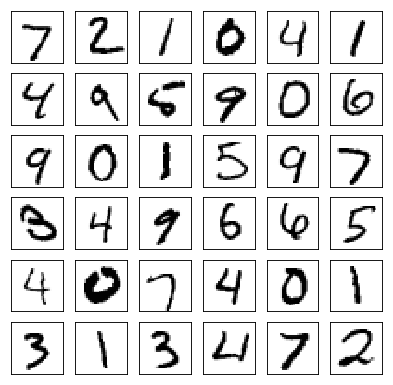

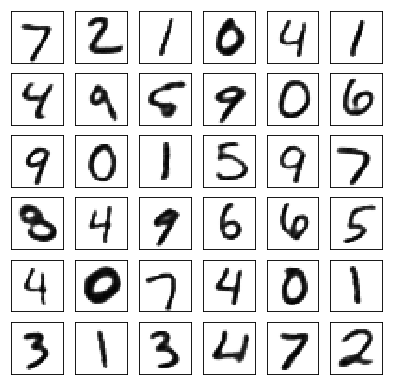

Epoch 21:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00714 / 0.00692
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26920 / 0.27107
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26922 / 0.27112
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26924 / 0.27116
  Loss for ConvAE BN=True DP=False FC=None              : 0.00625 / 0.00615
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.02460 / 0.02088
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.00854 / 0.01452
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00687 / 0.01414
  Loss for ConvAE BN=True DP=True FC=None               : 0.05336 / 0.02743
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.14526 / 0.09751
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.06914 / 0.03625
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.05726 / 0.02927
Epoch 22:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00704 / 

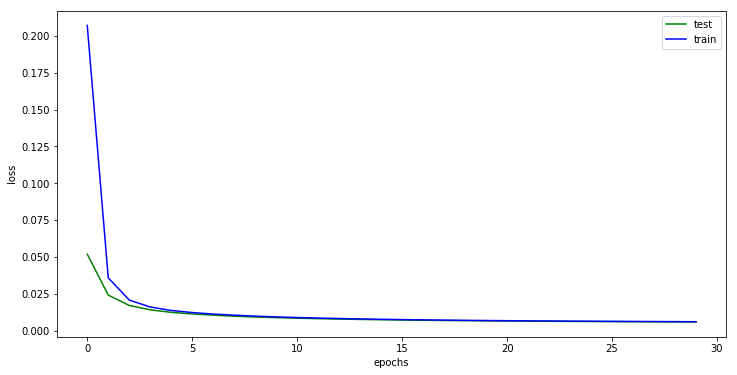

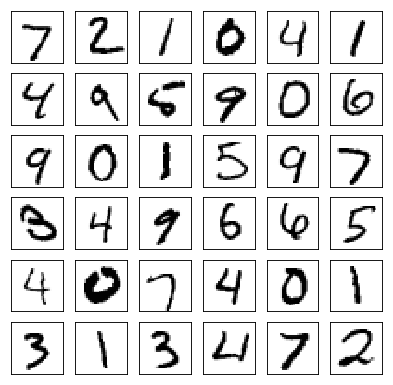

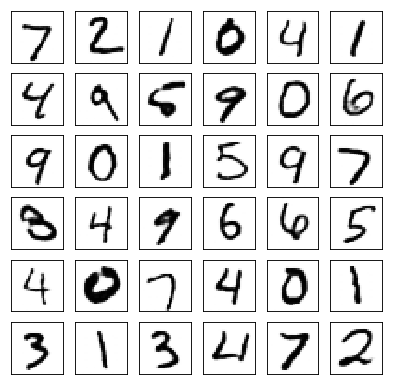


------------- ConvAE BN=False DP=False FC=(128, 128) -------------



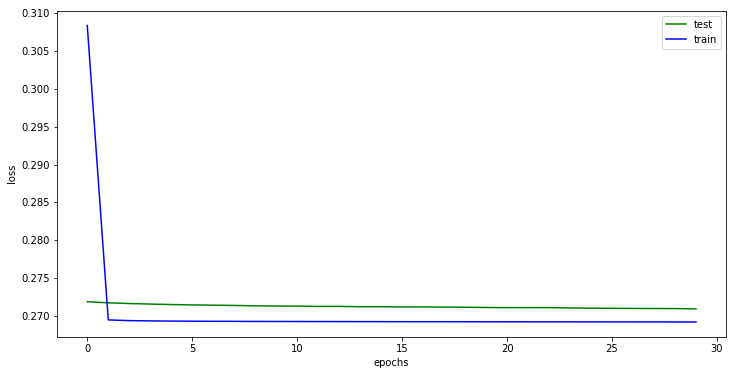

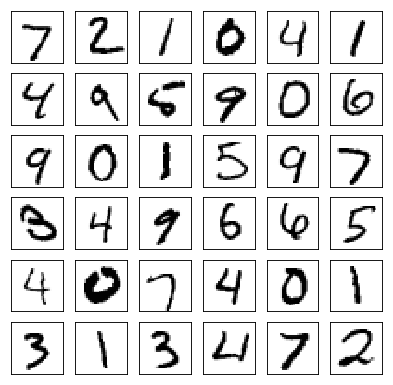

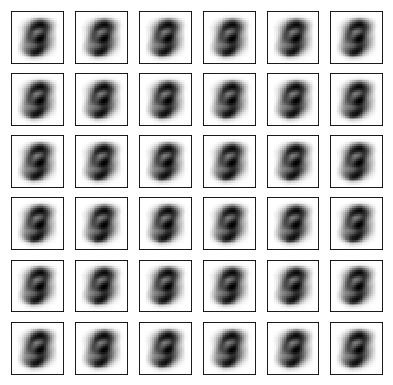


------------- ConvAE BN=False DP=False FC=(1024, 1024) -------------



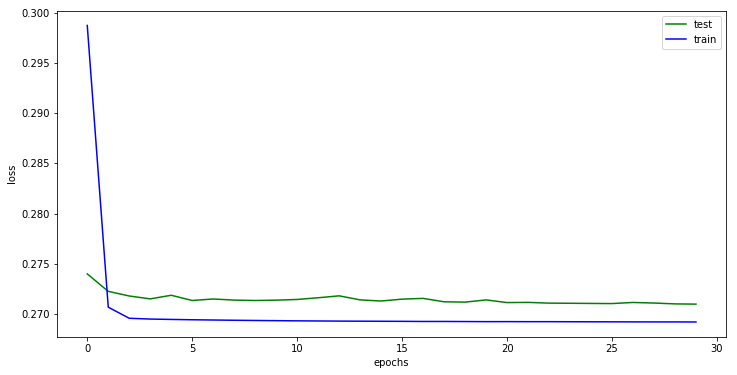

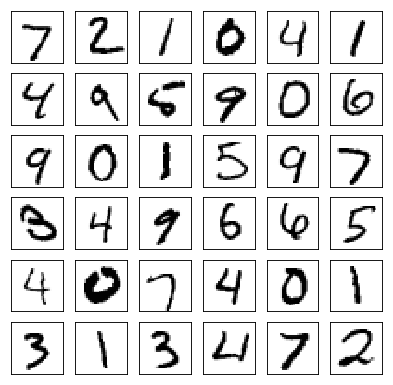

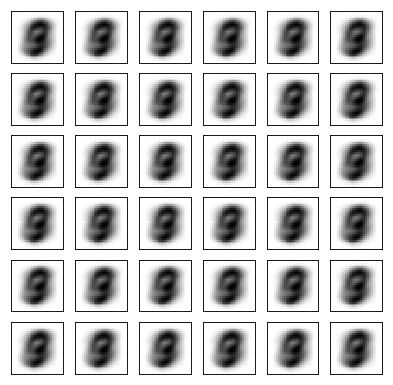


------------- ConvAE BN=False DP=False FC=(2048, 2048) -------------



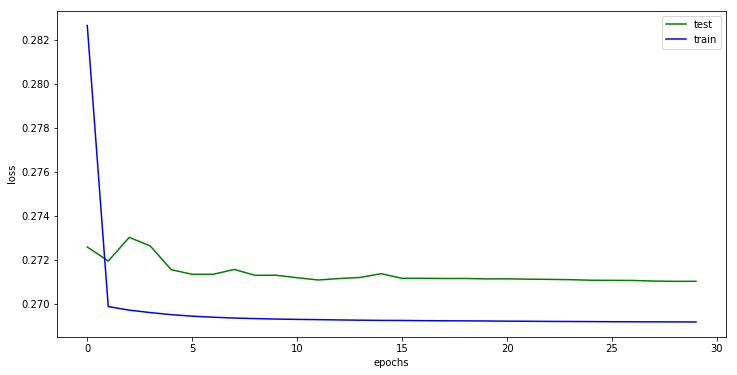

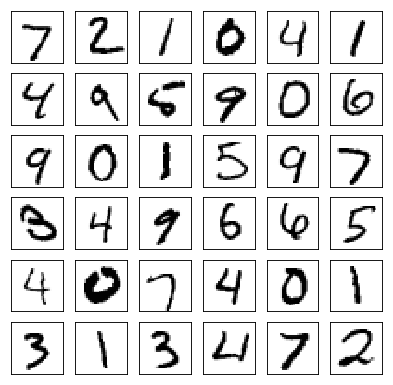

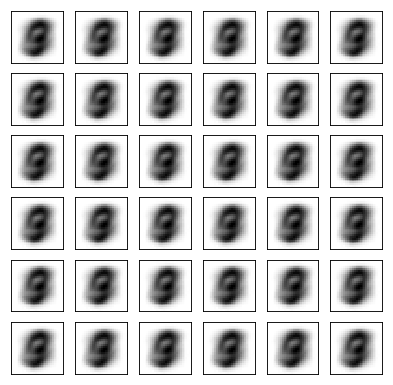


------------- ConvAE BN=True DP=False FC=None -------------



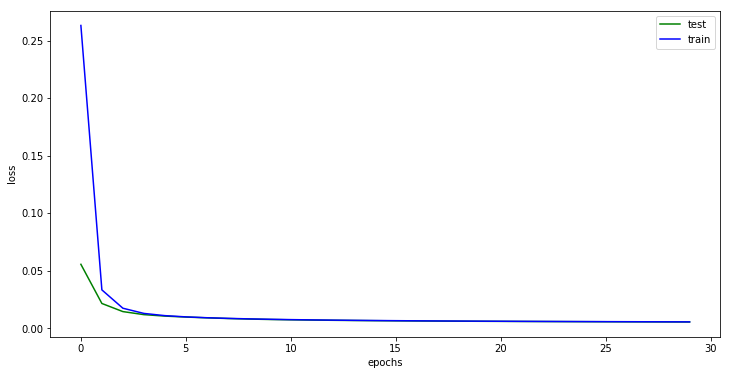

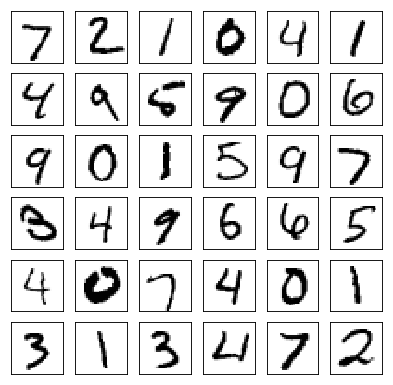

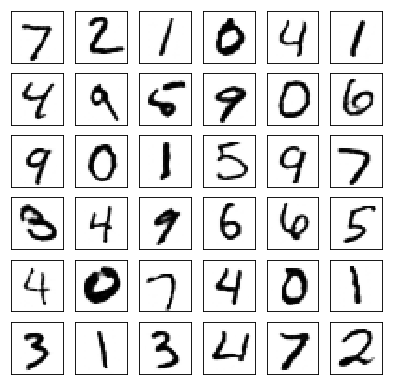


------------- ConvAE BN=True DP=False FC=(128, 128) -------------



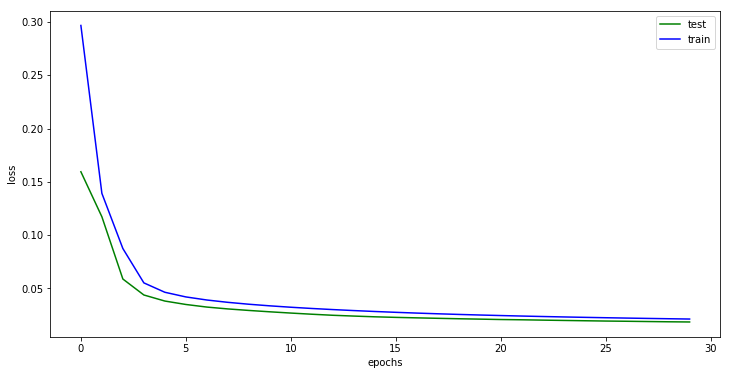

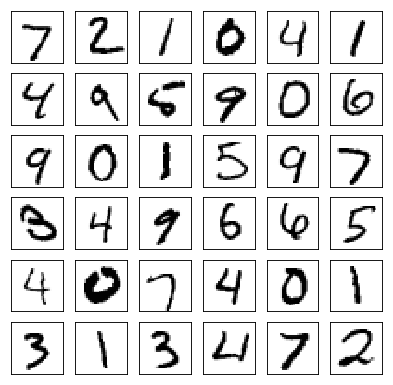

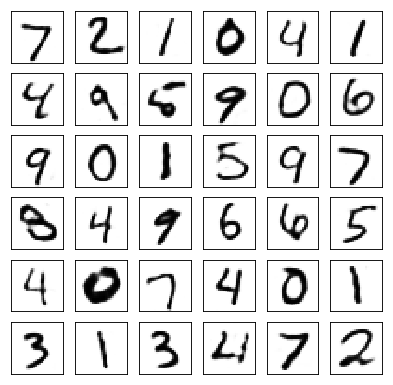


------------- ConvAE BN=True DP=False FC=(1024, 1024) -------------



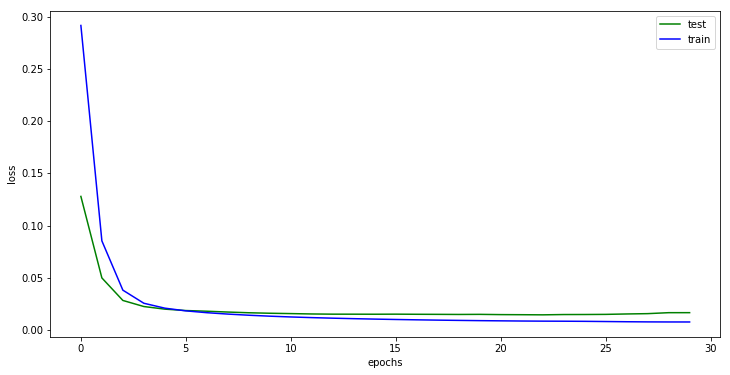

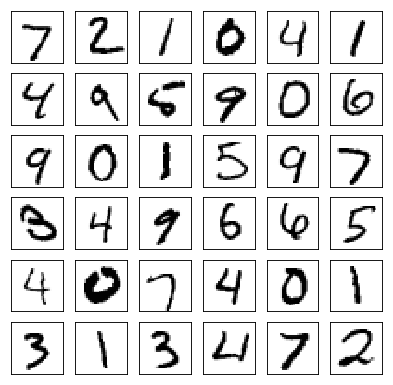

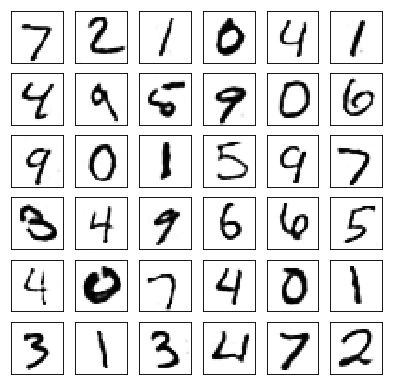


------------- ConvAE BN=True DP=False FC=(2048, 2048) -------------



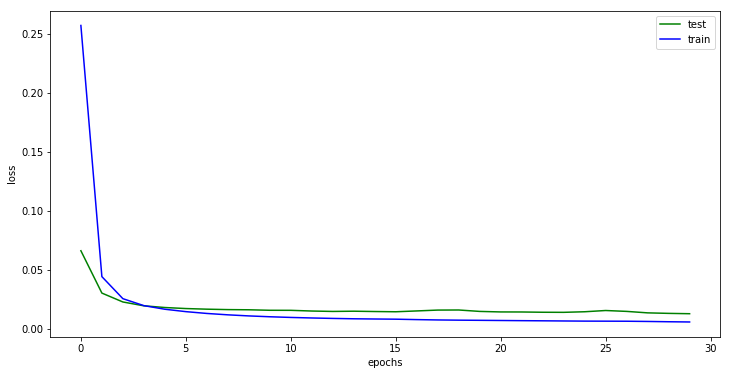

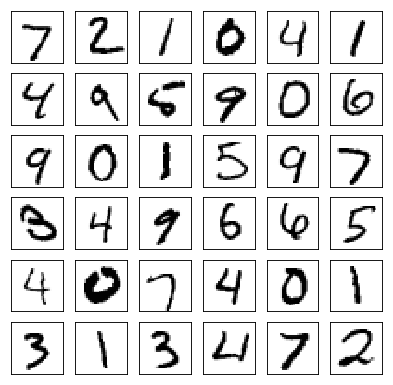

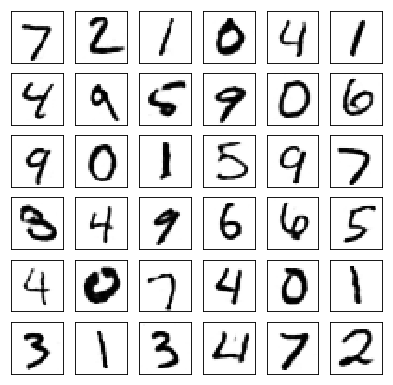


------------- ConvAE BN=True DP=True FC=None -------------



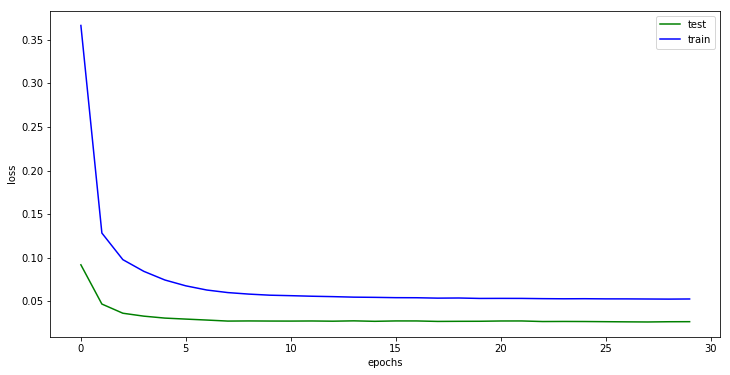

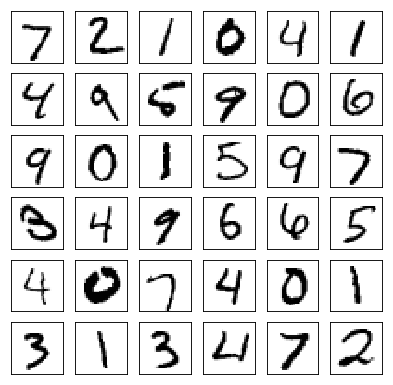

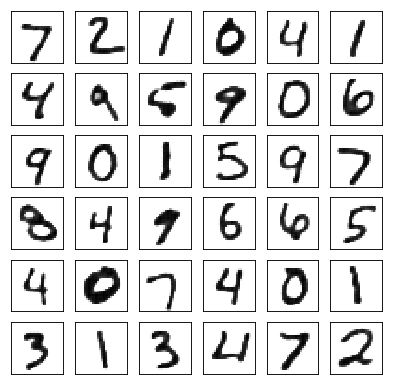


------------- ConvAE BN=True DP=True FC=(128, 128) -------------



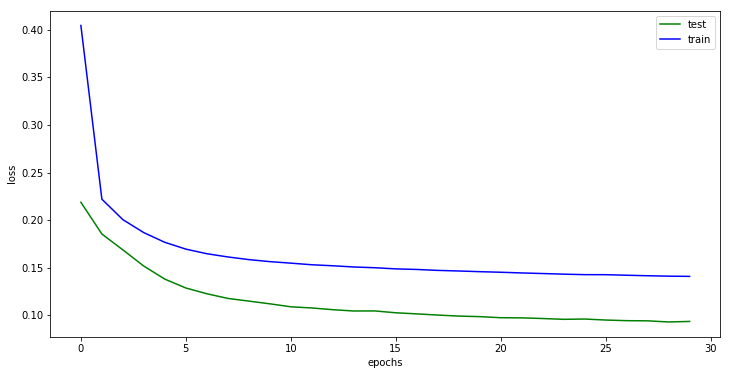

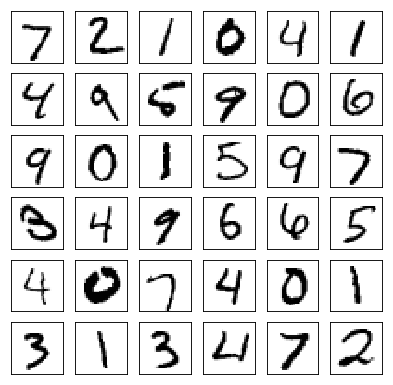

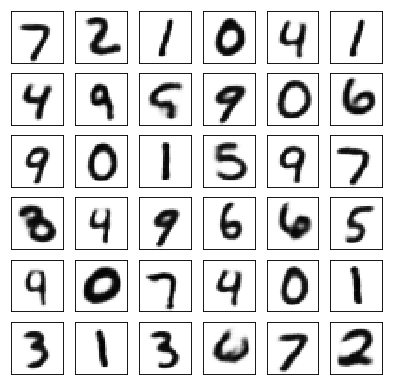


------------- ConvAE BN=True DP=True FC=(1024, 1024) -------------



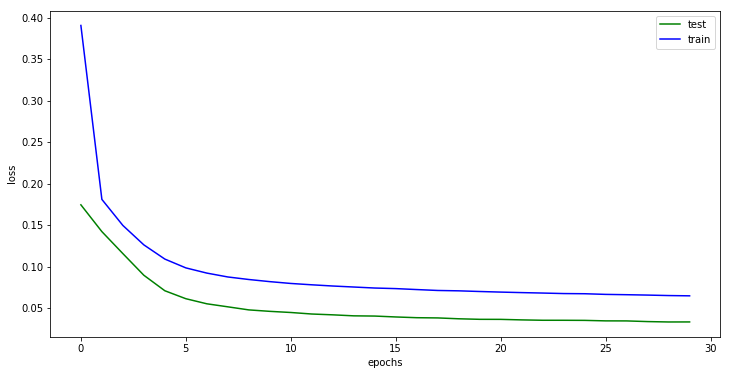

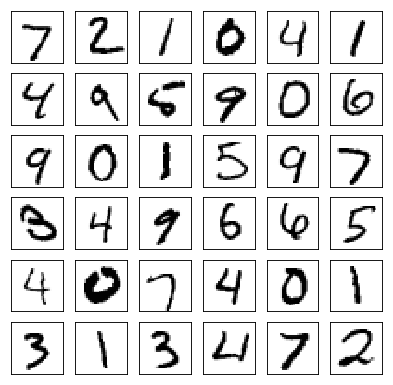

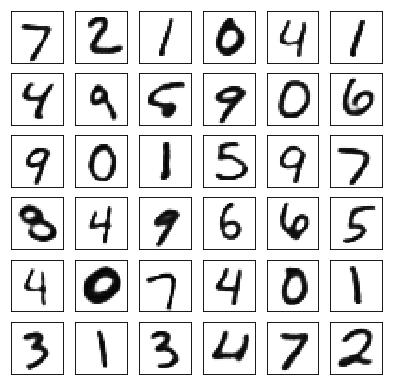


------------- ConvAE BN=True DP=True FC=(2048, 2048) -------------



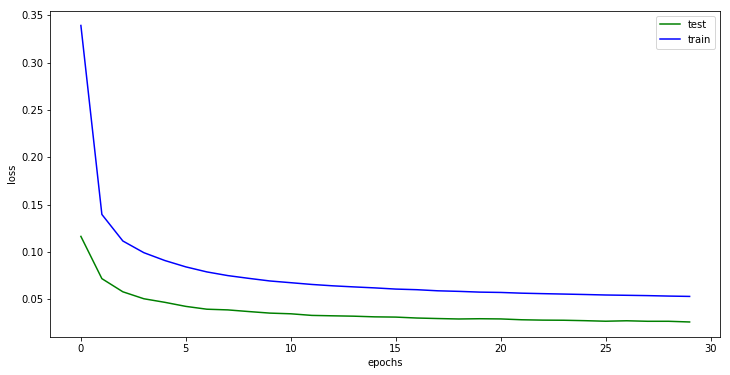

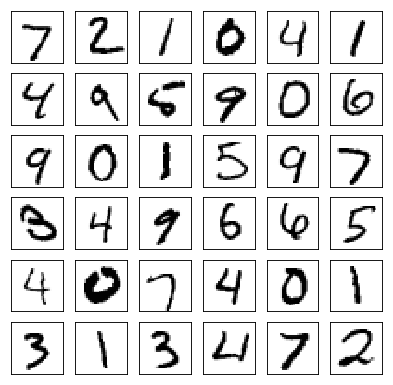

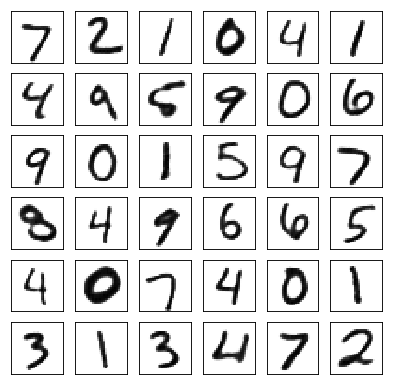

Epoch 31:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00639 / 0.00622
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26917 / 0.27088
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26919 / 0.27094
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26920 / 0.27102
  Loss for ConvAE BN=True DP=False FC=None              : 0.00567 / 0.00558
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.02106 / 0.01835
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.00741 / 0.01477
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00551 / 0.01265
  Loss for ConvAE BN=True DP=True FC=None               : 0.05269 / 0.02629
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.14044 / 0.09228
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.06429 / 0.03364
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.05291 / 0.02612
Epoch 32:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00634 / 

Epoch 40:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00600 / 0.00585
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26916 / 0.27078
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26916 / 0.27083
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26918 / 0.27092
  Loss for ConvAE BN=True DP=False FC=None              : 0.00537 / 0.00530
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.01914 / 0.01700
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.00691 / 0.01447
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00483 / 0.01267
  Loss for ConvAE BN=True DP=True FC=None               : 0.05201 / 0.02595
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.13750 / 0.09034
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.06121 / 0.03161
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.05026 / 0.02469

------------- ConvAE BN=False DP=False FC=None -------------



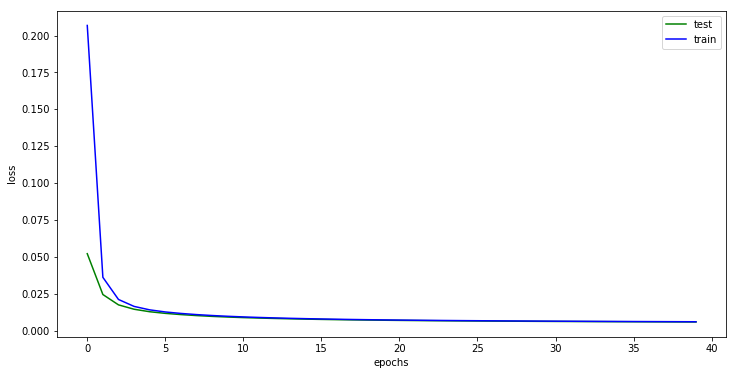

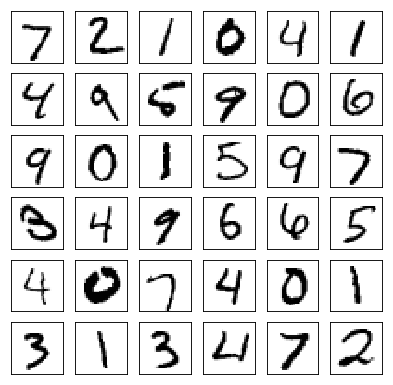

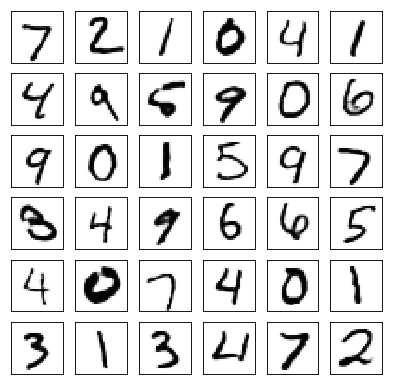


------------- ConvAE BN=False DP=False FC=(128, 128) -------------



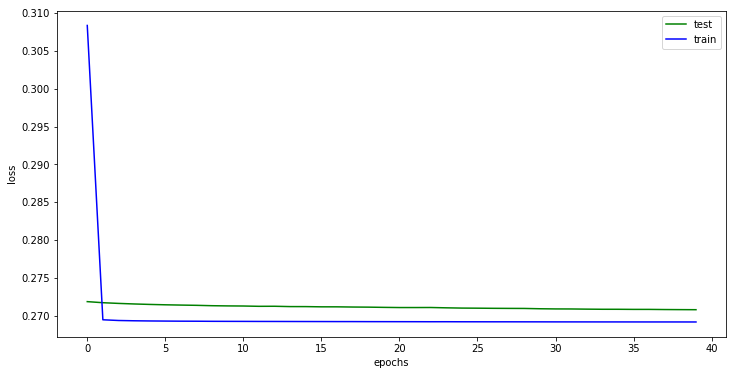

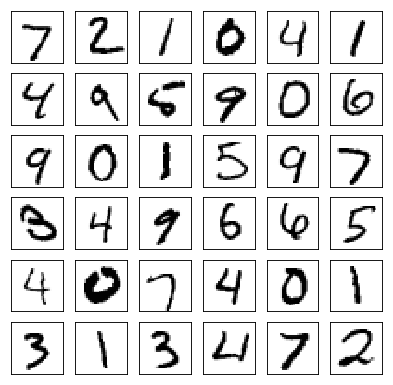

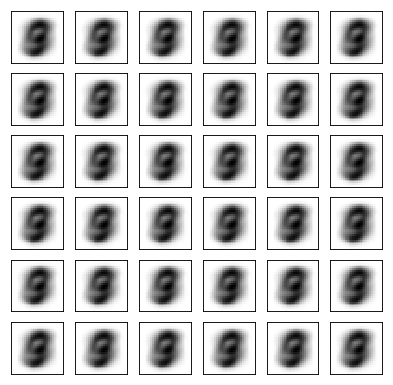


------------- ConvAE BN=False DP=False FC=(1024, 1024) -------------



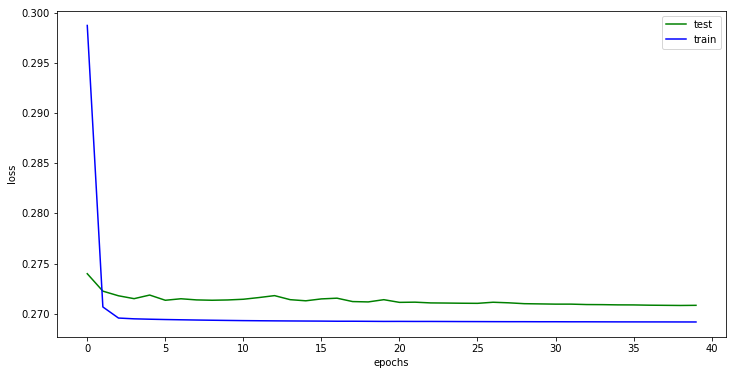

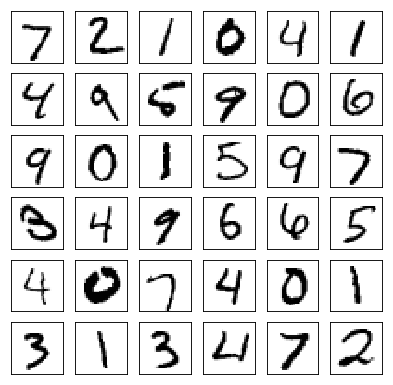

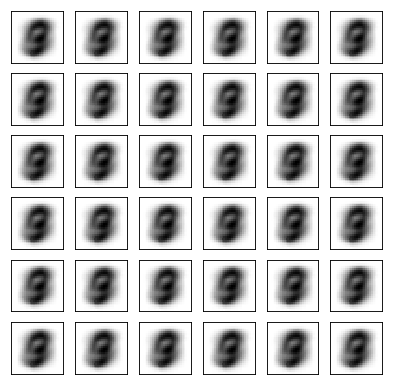


------------- ConvAE BN=False DP=False FC=(2048, 2048) -------------



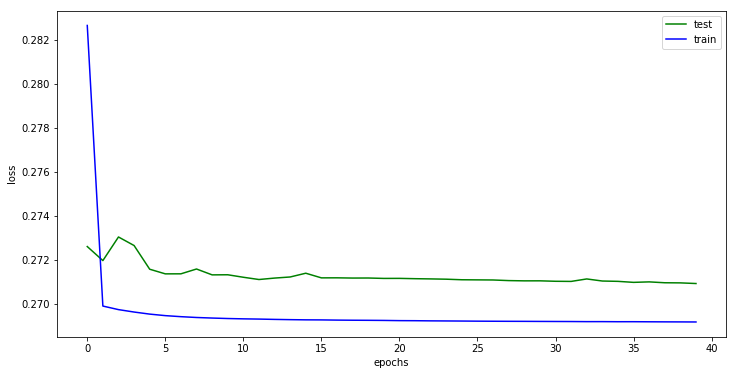

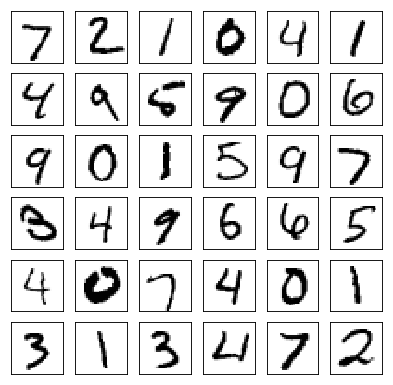

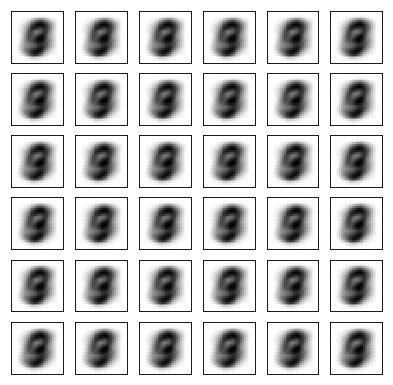


------------- ConvAE BN=True DP=False FC=None -------------



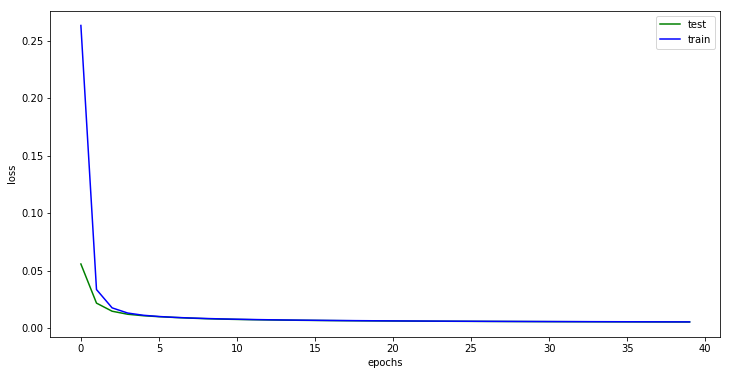

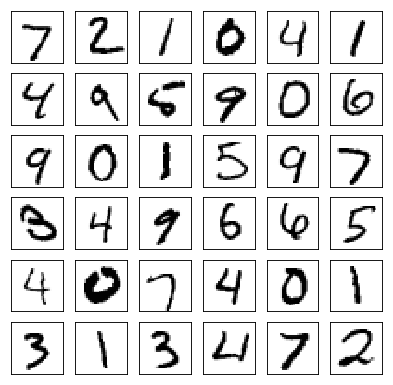

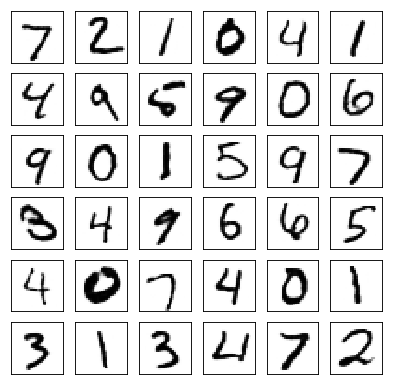


------------- ConvAE BN=True DP=False FC=(128, 128) -------------



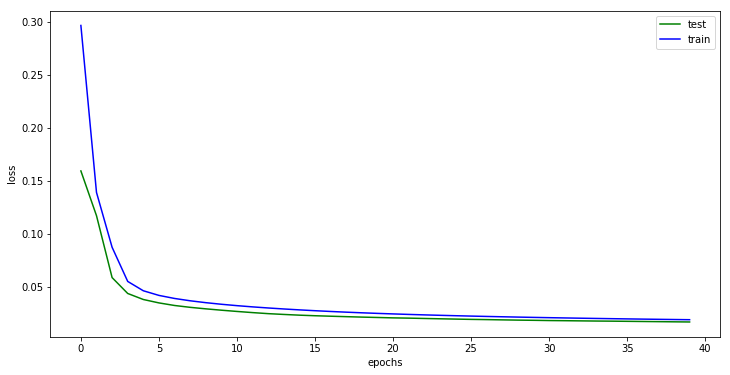

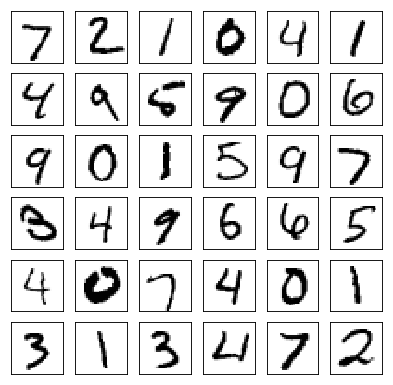

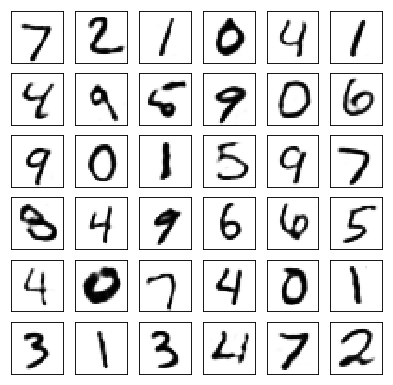


------------- ConvAE BN=True DP=False FC=(1024, 1024) -------------



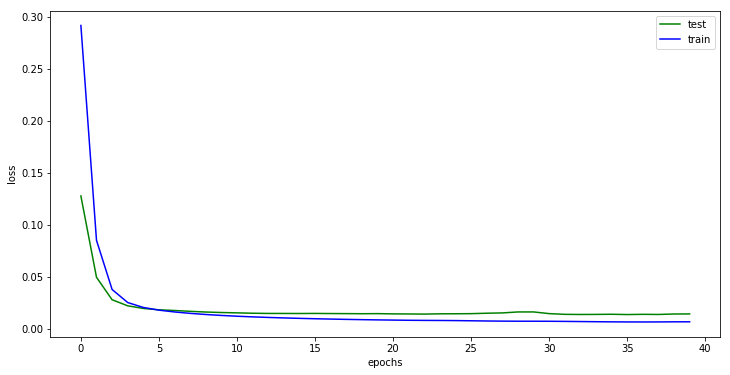

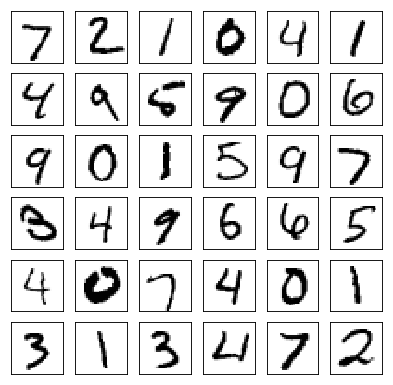

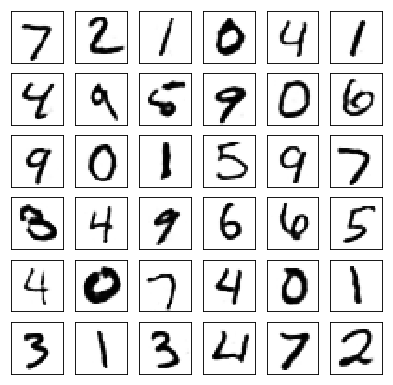


------------- ConvAE BN=True DP=False FC=(2048, 2048) -------------



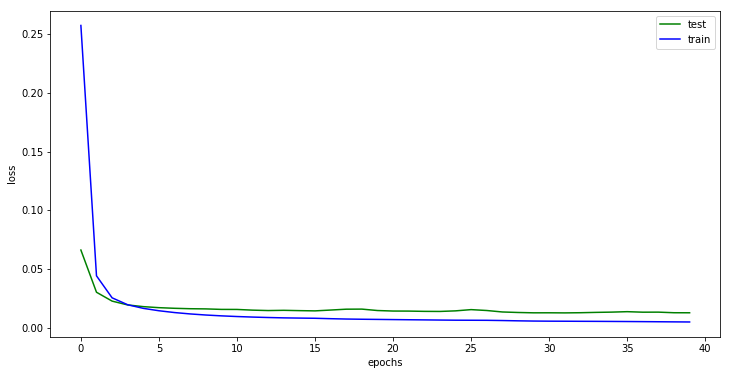

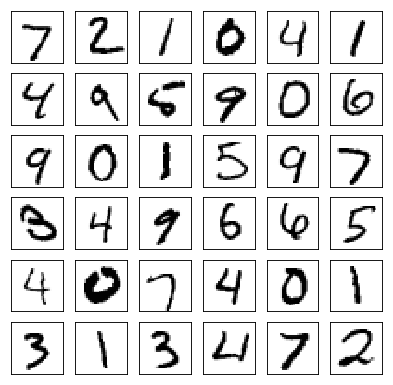

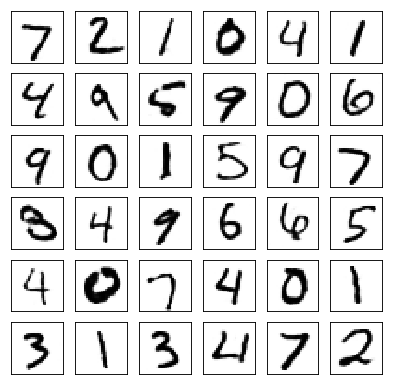


------------- ConvAE BN=True DP=True FC=None -------------



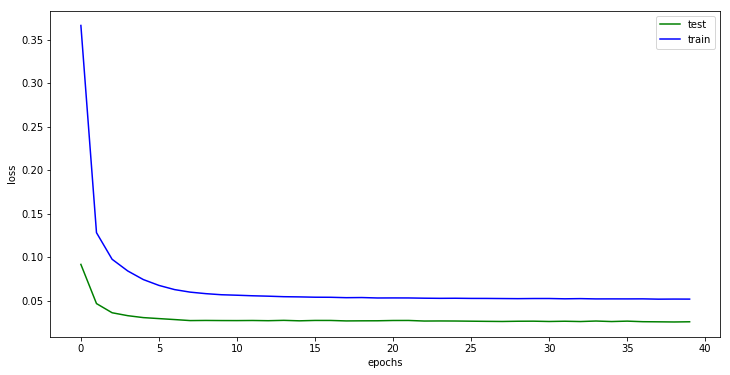

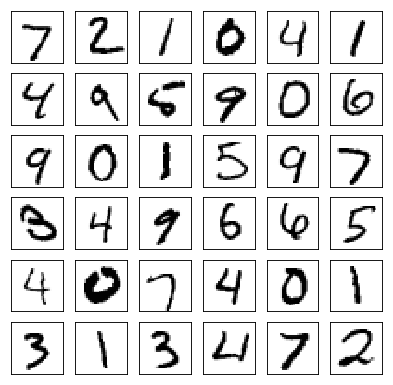

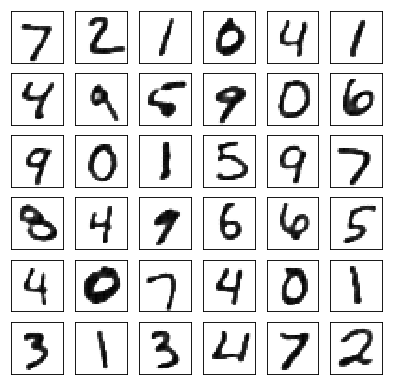


------------- ConvAE BN=True DP=True FC=(128, 128) -------------



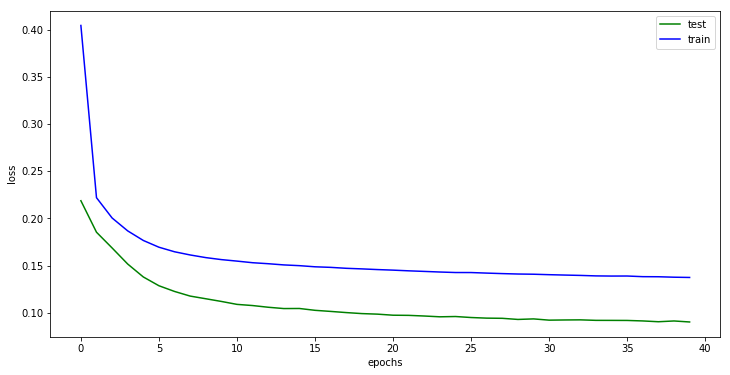

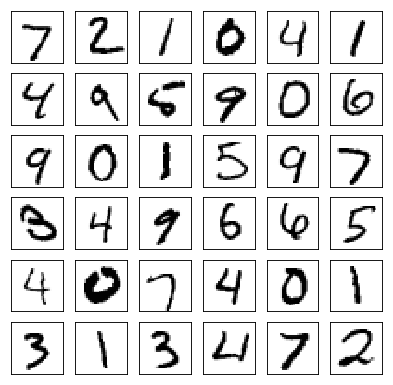

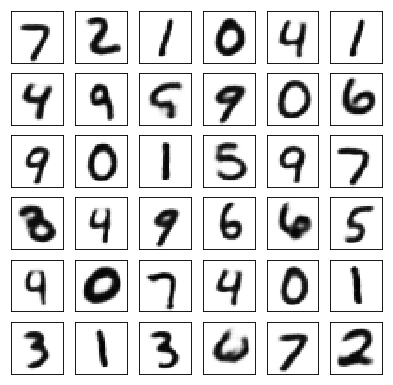


------------- ConvAE BN=True DP=True FC=(1024, 1024) -------------



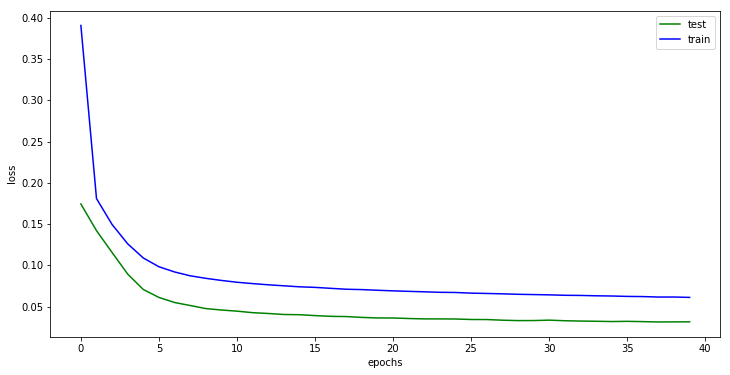

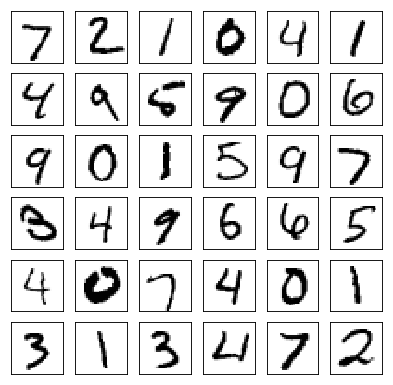

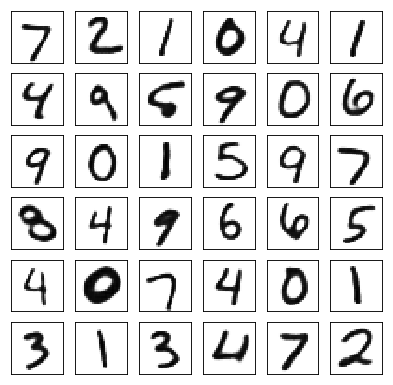


------------- ConvAE BN=True DP=True FC=(2048, 2048) -------------



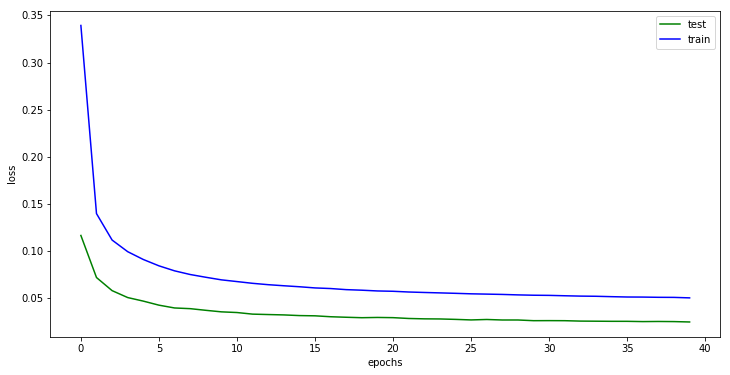

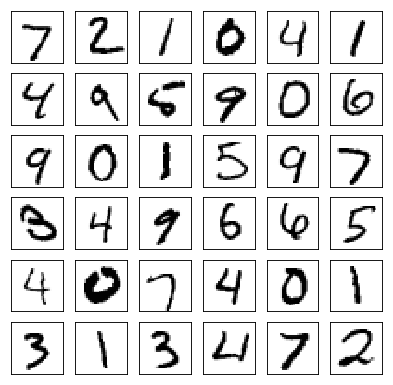

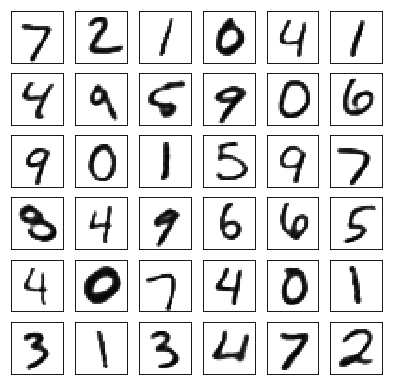

Epoch 41:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00597 / 0.00582
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26916 / 0.27077
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26916 / 0.27080
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26917 / 0.27091
  Loss for ConvAE BN=True DP=False FC=None              : 0.00534 / 0.00527
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.01897 / 0.01685
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.00670 / 0.01408
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00476 / 0.01249
  Loss for ConvAE BN=True DP=True FC=None               : 0.05210 / 0.02634
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.13749 / 0.09034
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.06114 / 0.03103
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.05009 / 0.02429
Epoch 42:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00593 / 

Epoch 50:
  Loss for ConvAE BN=False DP=False FC=None             : 0.00570 / 0.00557
  Loss for ConvAE BN=False DP=False FC=(128, 128)       : 0.26915 / 0.27066
  Loss for ConvAE BN=False DP=False FC=(1024, 1024)     : 0.26915 / 0.27067
  Loss for ConvAE BN=False DP=False FC=(2048, 2048)     : 0.26916 / 0.27081
  Loss for ConvAE BN=True DP=False FC=None              : 0.00515 / 0.00510
  Loss for ConvAE BN=True DP=False FC=(128, 128)        : 0.01769 / 0.01596
  Loss for ConvAE BN=True DP=False FC=(1024, 1024)      : 0.00611 / 0.01395
  Loss for ConvAE BN=True DP=False FC=(2048, 2048)      : 0.00423 / 0.01238
  Loss for ConvAE BN=True DP=True FC=None               : 0.05185 / 0.02573
  Loss for ConvAE BN=True DP=True FC=(128, 128)         : 0.13471 / 0.08866
  Loss for ConvAE BN=True DP=True FC=(1024, 1024)       : 0.05901 / 0.02980
  Loss for ConvAE BN=True DP=True FC=(2048, 2048)       : 0.04824 / 0.02379

------------- ConvAE BN=False DP=False FC=None -------------



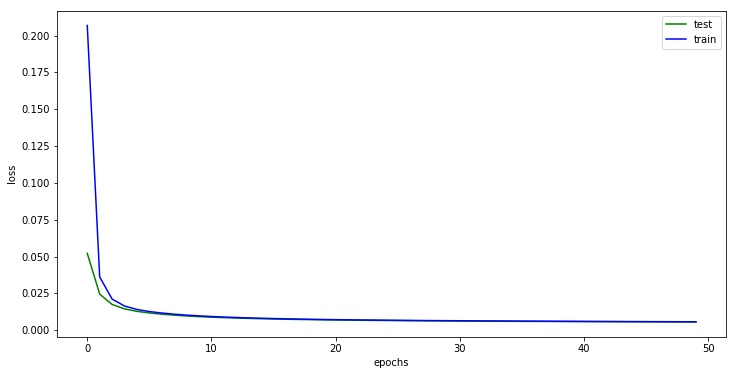

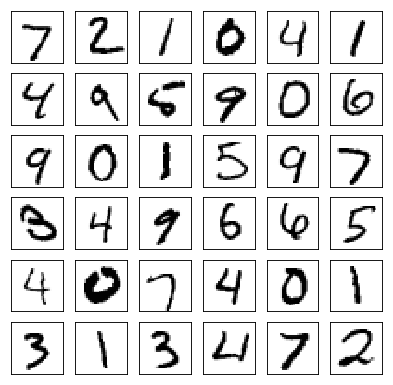

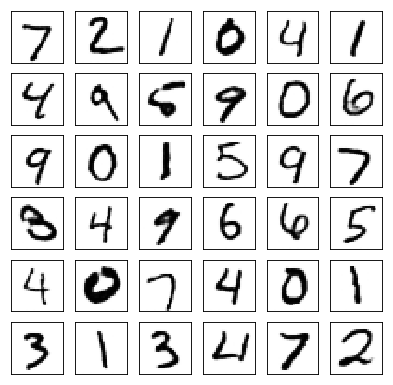


------------- ConvAE BN=False DP=False FC=(128, 128) -------------



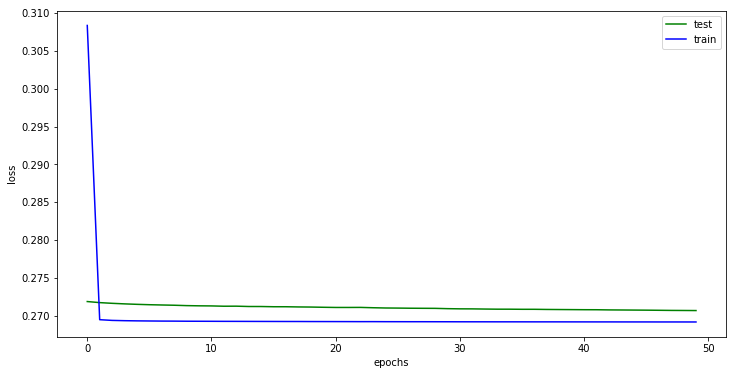

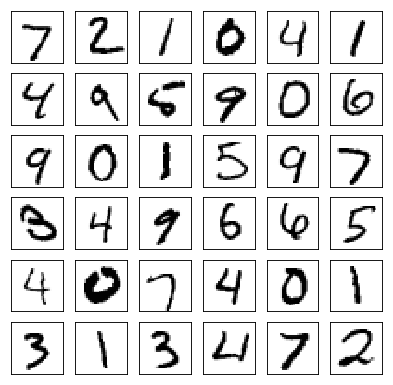

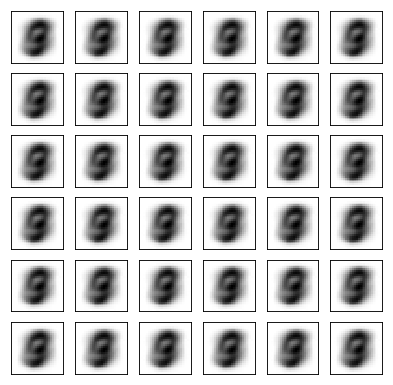


------------- ConvAE BN=False DP=False FC=(1024, 1024) -------------



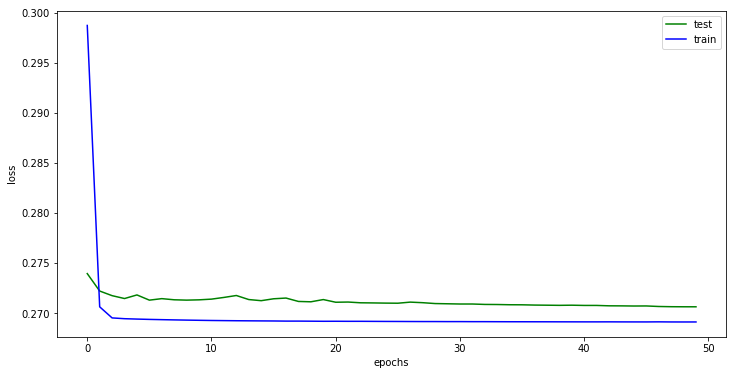

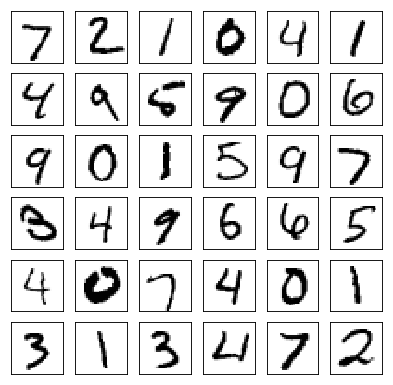

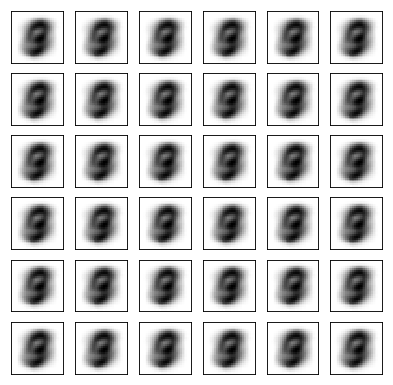


------------- ConvAE BN=False DP=False FC=(2048, 2048) -------------



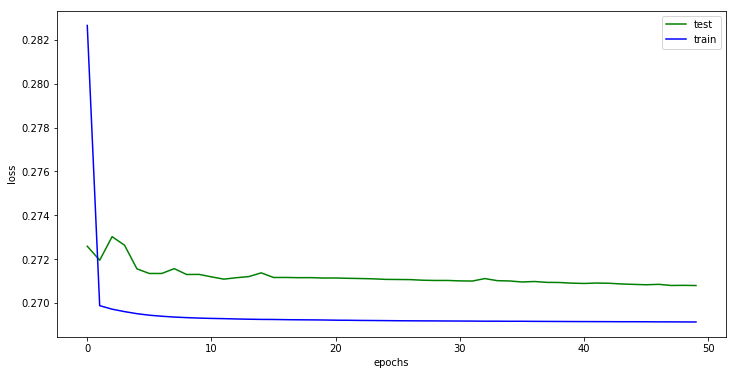

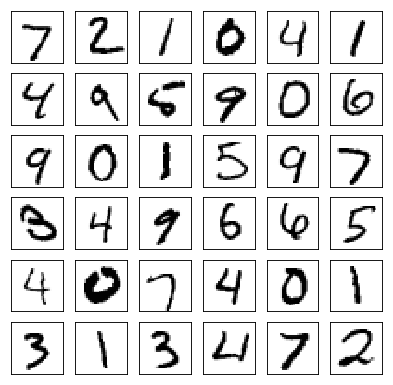

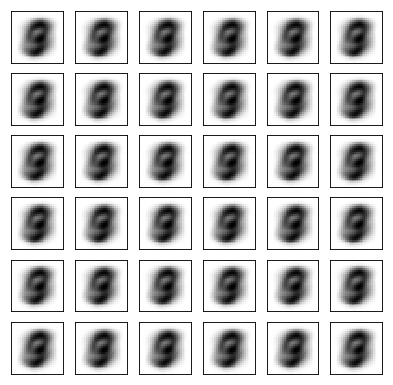


------------- ConvAE BN=True DP=False FC=None -------------



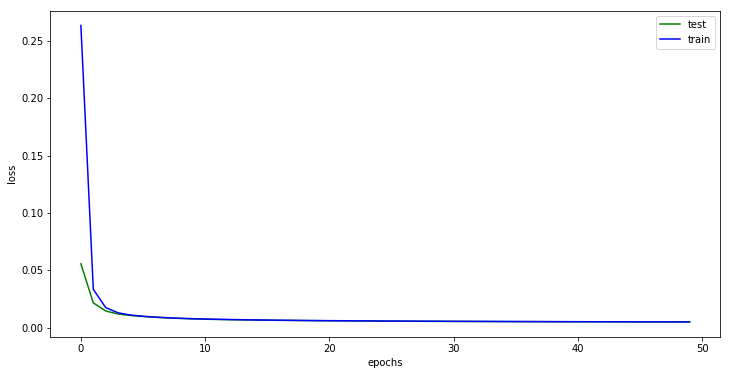

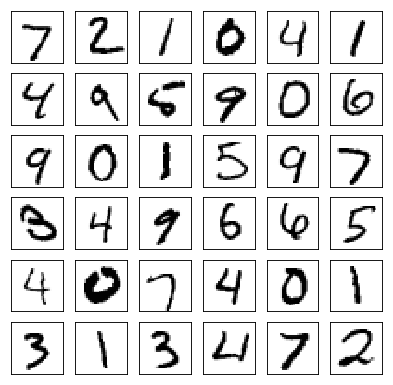

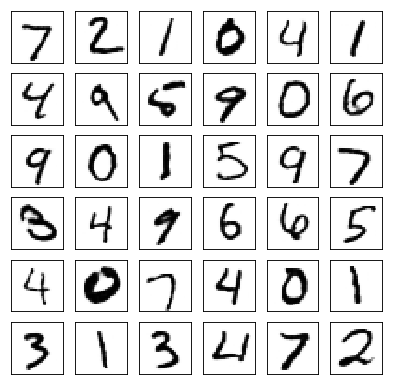


------------- ConvAE BN=True DP=False FC=(128, 128) -------------



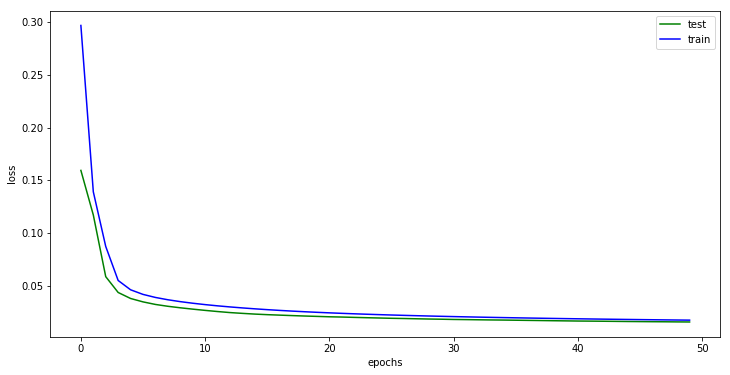

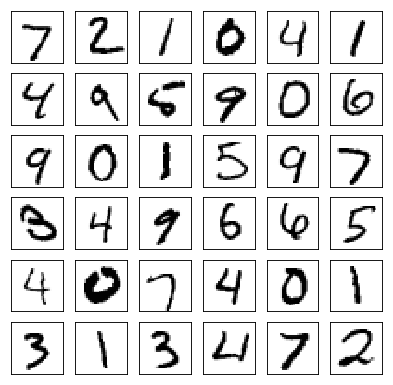

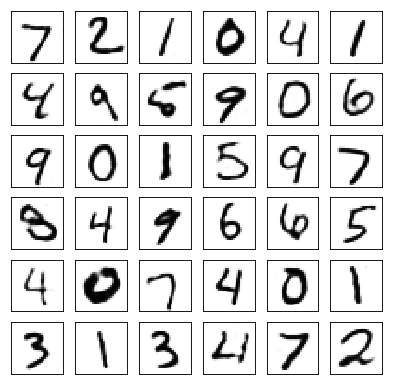


------------- ConvAE BN=True DP=False FC=(1024, 1024) -------------



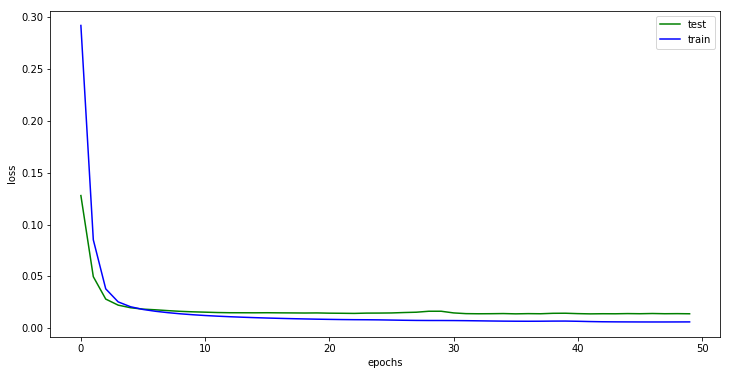

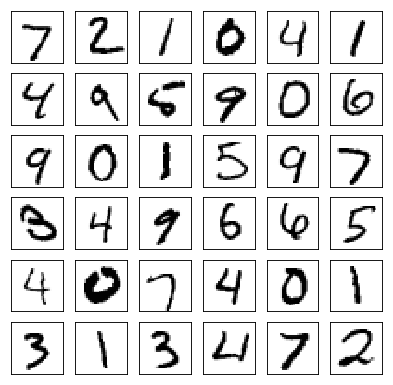

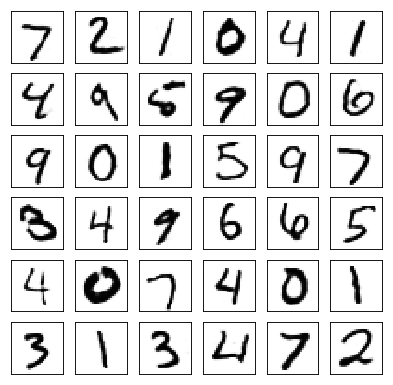


------------- ConvAE BN=True DP=False FC=(2048, 2048) -------------



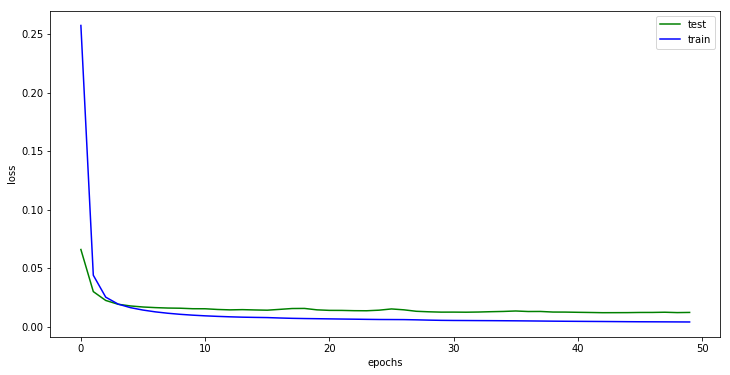

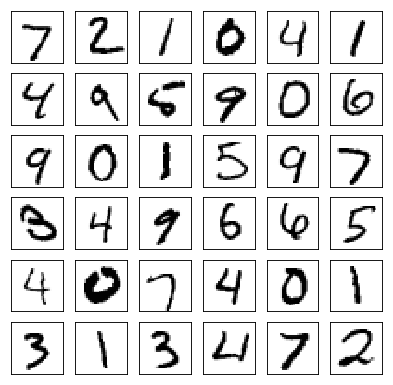

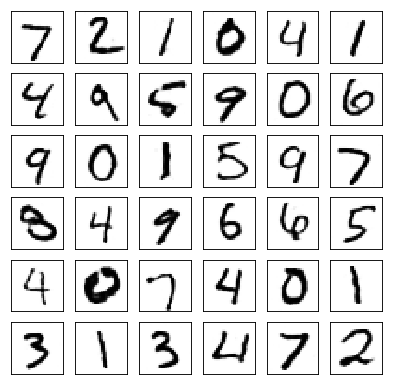


------------- ConvAE BN=True DP=True FC=None -------------



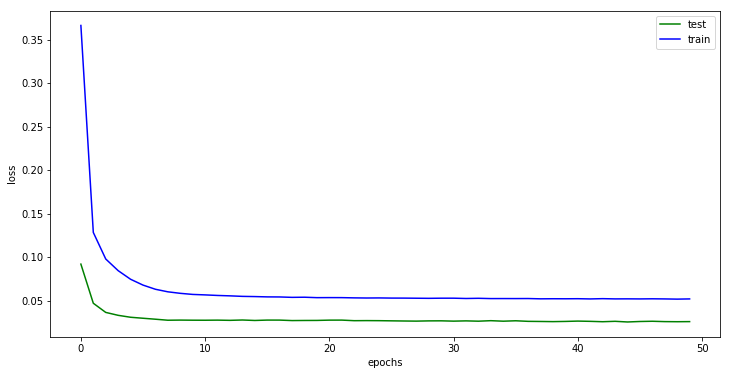

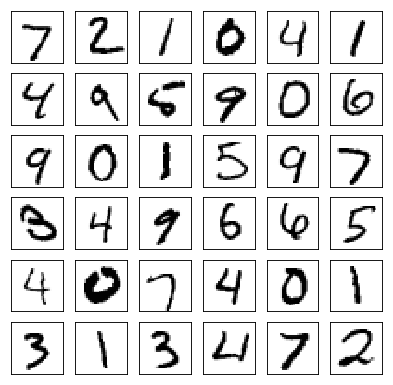

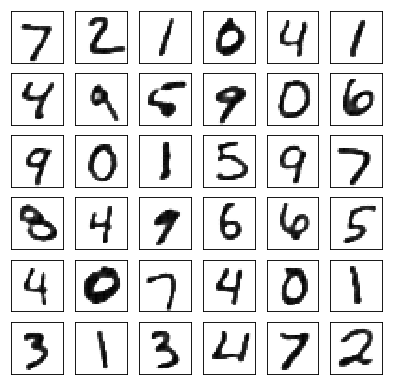


------------- ConvAE BN=True DP=True FC=(128, 128) -------------



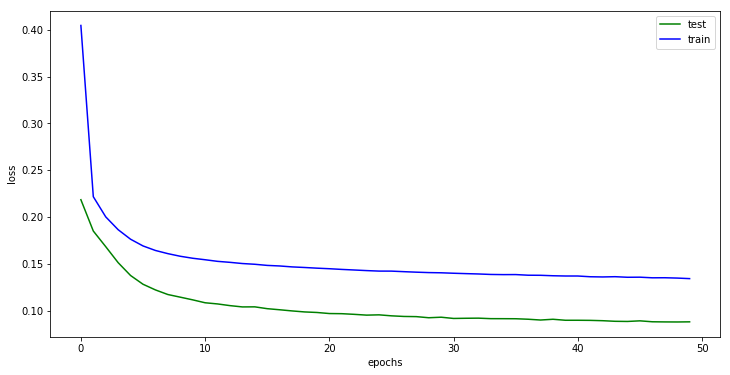

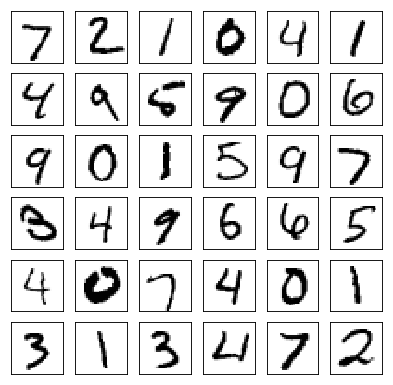

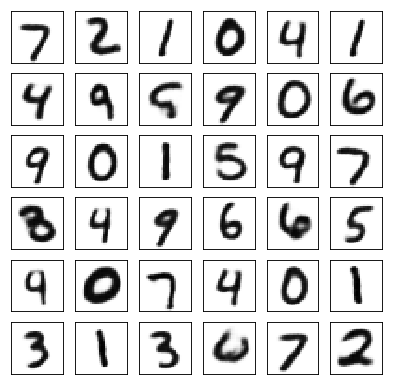


------------- ConvAE BN=True DP=True FC=(1024, 1024) -------------



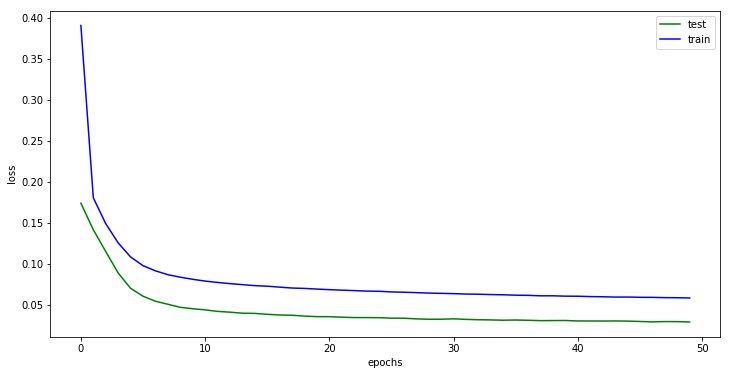

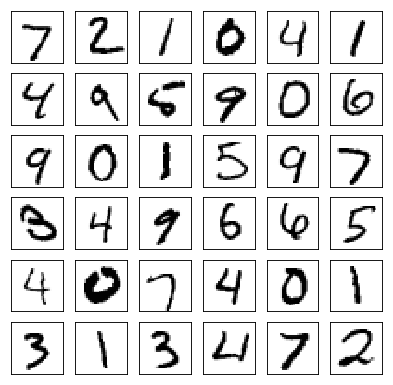

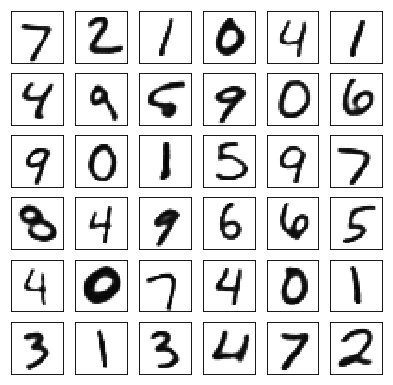


------------- ConvAE BN=True DP=True FC=(2048, 2048) -------------



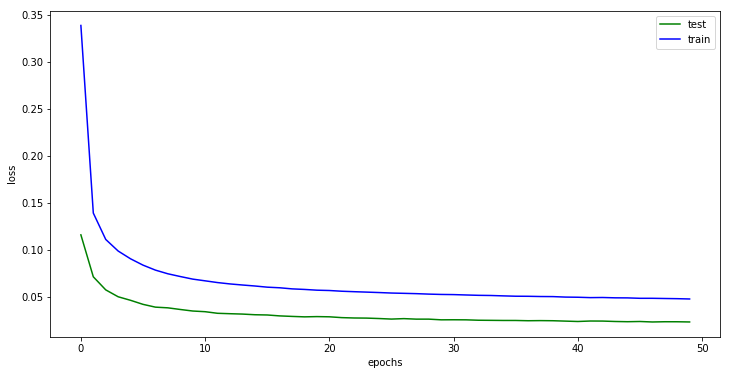

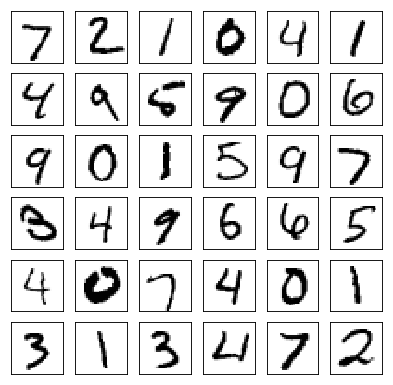

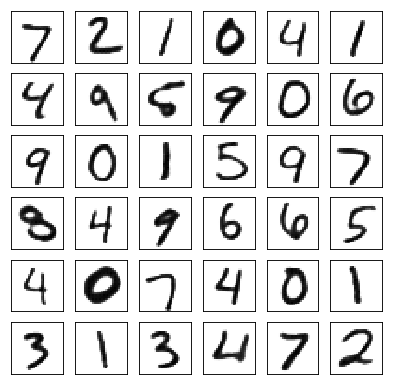

CPU times: user 1h 55min 33s, sys: 5min 35s, total: 2h 1min 8s
Wall time: 1h 58min 55s


In [18]:
%%time
for epoch in range(1, 51):
    losses = train(models, train_dl, test_dl)
    
    for i, (trn, tst) in enumerate(losses):
        train_losses[i].append(trn)
        test_losses[i].append(tst)
    
    if epoch % 10 == 0:
        for i, m in enumerate(models):
            print(f"\n------------- {m.name} -------------\n")
            plot_losses(train_losses[i], test_losses[i])
            img, _ = next(iter(test_dl))
            plot_ae(m, img)



In [19]:
for m in models:
    torch.save(m.state_dict(), PATH / f'{m.name}.model')

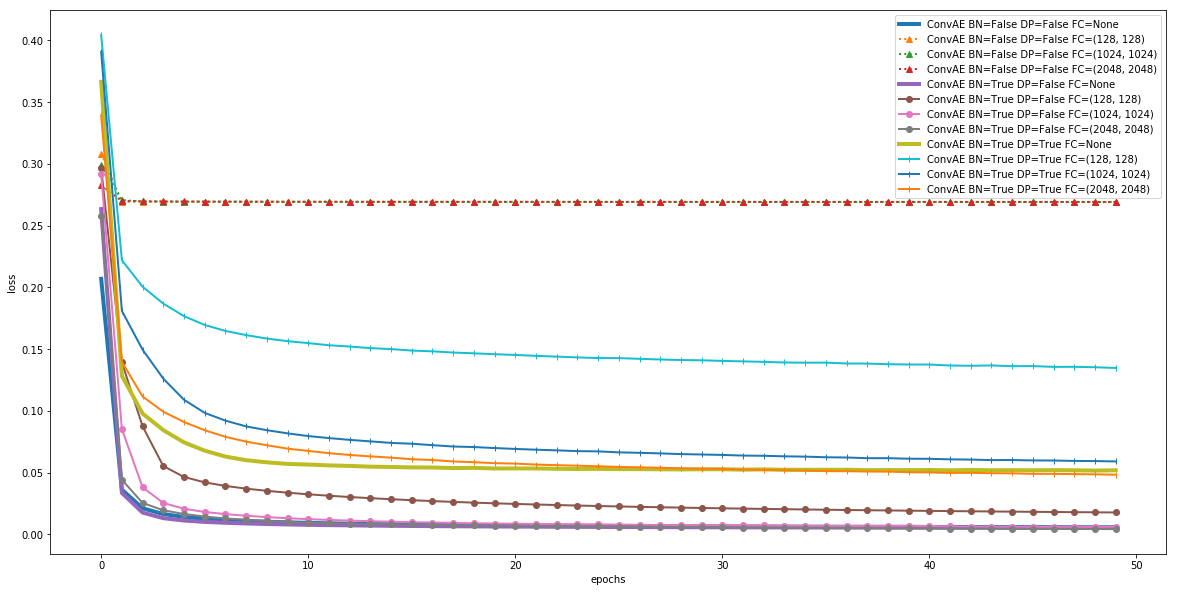

In [20]:
plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = train_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

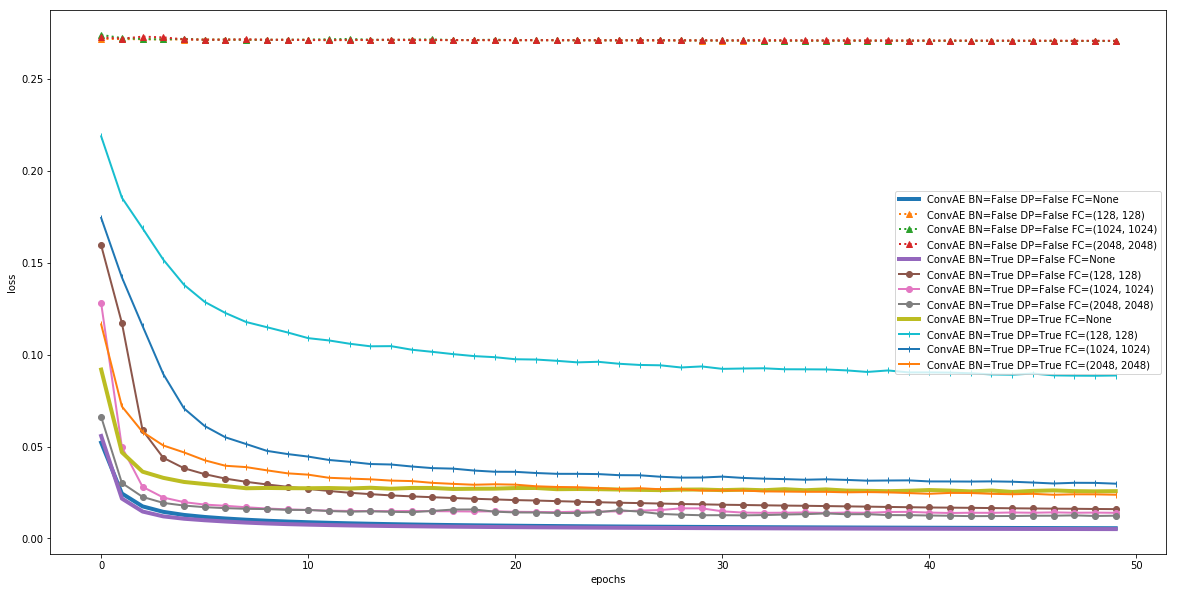

In [21]:
plt.figure(figsize=(20,10))

for i, m in enumerate(models):
    line = test_losses[i]
    if "FC=None" in m.name:
        plt.plot(line, label=m.name, linestyle='-',
        linewidth=4)
    elif "BN=True" in m.name and "DP=False" in m.name:
        plt.plot(line, label=m.name, marker='o', linestyle='-',
        linewidth=2, markersize=6)
    elif "BN=True" in m.name and "DP=True" in m.name:
        plt.plot(line, label=m.name, marker='|', linestyle='-',
        linewidth=2, markersize=6)
    else:
        plt.plot(line, label=m.name, marker='^', linestyle=':',
        linewidth=2, markersize=6)
        
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()